In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import norm, svds

from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim

from polara.lib.tensor import hooi
from polara.lib.sparse import tensor_outer_at

from dataprep import full_preproccessing
from utils import *
# from RecVAE.utils import *
# from RecVAE.model import VAE as RecVAE

In [2]:
def fix_torch_seed(seed, conv_determinism=True):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # settings below may affect computational performance
    # see https://pytorch.org/docs/stable/notes/randomness.html:
    if conv_determinism:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def set_random_seed(seed):
#     torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
# fix_torch_seed(42)
set_random_seed(42)

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda', index=0)

# Data preprocessing

In [6]:
data = pd.read_csv('Amazon_Video_Games.csv')
data.rename(columns = {'reviewerID' : 'userid', 'asin' : 'movieid', "overall" : "rating", "unixReviewTime" : "timestamp"}, inplace = True)

In [7]:
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing(data)

There are 24303 users
Filtered 17693 invalid observations.


In [6]:
check = pd.concat((training, testset_valid, holdout_valid, testset, holdout))

In [9]:
check.shape[0] / check.userid.nunique() / check.movieid.nunique() * 100

0.10033970223792682

In [7]:
check.shape[0]

160585

In [8]:
check.userid.nunique(), check.movieid.nunique()

(16156, 9906)

In [20]:
del data

# Baselines

## TopPop

In [21]:
def build_popularity_model(trainset, trainset_description):
    itemid = trainset_description['items']
    item_popularity = trainset[itemid].value_counts()
    return item_popularity

def popularity_model_scoring(params, testset, testset_description):
    item_popularity = params
    n_items = item_popularity.index.max() + 1
    n_users = testset_description['n_test_users']
    # fill in popularity scores for each item with indices from 0 to n_items-1
    popularity_scores = np.zeros(n_items,)
    popularity_scores[item_popularity.index] = item_popularity.values
    # same scores for each test user
    scores = np.tile(popularity_scores, n_users).reshape(n_users, n_items)
    return scores

## Normalized PureSVD

In [16]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), shape=(useridx.values.max() + 1, data_description["n_items"]), dtype='f8')

def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    #print(source_matrix.shape)
    D = norm(source_matrix, axis=0)
    A = source_matrix.dot(diags(D**(config['f']-1)))
    _, _, vt = svds(A, k=config['rank'], return_singular_vectors='vh')
#     singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors

def svd_model_scoring(params, data, data_description):
    item_factors = params
    test_data = data.assign(
        userid = pd.factorize(data['userid'])[0]
    )
    test_matrix = matrix_from_observations(test_data, data_description)
    #print(test_matrix.shape, item_factors.shape)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

## EASEr

In [32]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), shape=(useridx.values.max() + 1, data_description["n_items"]), dtype='f8')

def easer(data, data_description, lmbda=500):
    X = matrix_from_observations(data, data_description)
    G = X.T.dot(X)
    diag_indices = np.diag_indices(G.shape[0])
    G[diag_indices] += lmbda
    P = np.linalg.inv(G.A)
    B = P / (-np.diag(P))
    B[diag_indices] = 0
    
    return B

def easer_scoring(params, data, data_description):
    item_factors = params
    test_data = data.assign(
        userid = pd.factorize(data['userid'])[0]
    )
    test_matrix = matrix_from_observations(test_data, data_description)
    scores = test_matrix.dot(item_factors)
    return scores

## CoFFee

In [8]:
def tf_model_build(config, data, data_description):
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    idx = data[[userid, itemid, feedback]].values
    idx[:, -1] = idx[:, -1] - data_description['min_rating'] # works only for integer ratings!
    val = np.ones(idx.shape[0], dtype='f8')
    
    n_users = data_description["n_users"]
    n_items = data_description["n_items"]
    n_ratings = data_description["n_ratings"]
    shape = (n_users, n_items, n_ratings)
    core_shape = config['mlrank']
    num_iters = config["num_iters"]
    
    u0, u1, u2, g = hooi(
        idx, val, shape, core_shape,
        num_iters=num_iters,
        parallel_ttm=False, growth_tol=0.01,
    )
    return u0, u1, u2
        

def tf_scoring(params, data, data_description):
    user_factors, item_factors, feedback_factors = params
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    data = data.sort_values(userid)
    useridx = data[userid].values
    itemidx = data[itemid].values
    ratings = data[feedback].values
    ratings = ratings - data_description['min_rating'] # works only for integer ratings!
    
    tensor_outer = tensor_outer_at('cpu')
    # use the fact that test data is sorted by users for reduction:
    scores = tensor_outer(
        1.0,
        item_factors,
        feedback_factors,
        itemidx,
        ratings
    )
    scores = np.add.reduceat(scores, np.r_[0, np.where(np.diff(useridx))[0]+1])
    scores = np.tensordot(
        scores,
        feedback_factors[-1, :],
        axes=(2, 0)
    ).dot(item_factors.T)
    return scores

## Simple AE

In [8]:
class MVDataset(Dataset):
    def __init__(self, data, data_description, augment=False):
        self.augment = augment
        
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        self.matrix = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32)

    def __len__(self):
        return self.matrix.shape[0]

    def __getitem__(self, idx):
        if self.augment:
            num_noise = np.random.randint(0, int(0.1 * self.matrix.shape[1]))
            idxs = torch.randint(0, self.matrix.shape[1], size=(num_noise,))
            noised_input = self.matrix[idx].detach().clone().to_dense()
            noised_input[idxs] = torch.distributions.bernoulli.Bernoulli(0.5).sample(sample_shape=(num_noise,)).to(self.matrix.device)
            
            useridx = np.zeros_like(noised_input.cpu())
            itemidx = np.arange(self.matrix.shape[1])
            noised_input = torch.sparse_coo_tensor(np.array([itemidx,]), noised_input,
                                                   size=torch.Size((data_description["n_items"],)), dtype=torch.float32)
            return noised_input, self.matrix[idx]
        else:
            return self.matrix[idx], self.matrix[idx]

In [9]:
class baseAE(nn.Module):
    def __init__(self, n_items, hid):
        super(baseAE, self).__init__()
        self.V = nn.Linear(n_items, hid)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.VT = nn.Linear(hid, n_items)
#         torch.nn.init.xavier_uniform_(self.VT.weight)
        torch.nn.init.normal_(self.VT.weight, 0.0, std=1./np.sqrt(hid))
        self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # encode
        x = self.V(x)
        x = self.relu(x)
        # decode
        output = self.VT(x)
#         output = self.sigmoid(output)
        return output

In [10]:
def base_model(h, data_description, device):
    ae = baseAE(data_description['n_items'], h).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    return ae, criterion, optimizer, scheduler

## RecVAE

In [7]:
vae = RecVAE(600, 200, 1000)
sum(p.numel() for p in vae.parameters() if p.requires_grad)

2490400

# Tuning

## Normalized PureSVD

In [14]:
rank_grid = []
for i in range(5, 10):
    rank_grid.append(2 * 2 ** i)
    rank_grid.append(3 * 2 ** i)
    
rank_grid = np.array(rank_grid)

f_grid = np.linspace(0, 2, 21)

In [ ]:
hr_tf = {}
mrr_tf = {}
c_tf = {}
grid = list(zip(np.meshgrid(rank_grid, f_grid)[0].flatten(), np.meshgrid(rank_grid, f_grid)[1].flatten()))
for params in tqdm(grid):
    r, f = params
    svd_config = {'rank': int(r), 'f': f}
    svd_params = build_svd_model(svd_config, training, data_description)
    svd_scores = svd_model_scoring(svd_params, testset_valid, data_description)
    downvote_seen_items(svd_scores, testset_valid, data_description)
    svd_recs = topn_recommendations(svd_scores, topn=10)
    for alpha in [2,3,4,5]:
        hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(svd_recs, holdout_valid, data_description, alpha=alpha)
        hr_tf[f'r={r}, f={f:.2f}, alpha={alpha}'] = hr
        mrr_tf[f'r={r}, f={f:.2f}, alpha={alpha}'] = mrr
        c_tf[f'r={r}, f={f:.2f}, alpha={alpha}'] = C

In [ ]:
sorted(c_tf.items(), key=lambda x: x[1], reverse=True)

## EASEr

In [9]:
lambda_grid = np.arange(10, 510, 10)

In [10]:
hr_tf = {}
mrr_tf = {}
c_tf = {}
for lmbda in tqdm(lambda_grid):
    easer_params = easer(training, data_description, lmbda=lmbda)
    easer_scores = easer_scoring(easer_params, testset_valid, data_description)
    downvote_seen_items(easer_scores, testset_valid, data_description)
    easer_recs = topn_recommendations(easer_scores, topn=10)
    for alpha in [2,3,4,5]:
        hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(easer_recs, holdout_valid, data_description, alpha=alpha)
        hr_tf[f'lambda={lmbda}, alpha={alpha}'] = hr
        mrr_tf[f'lambda={lmbda}, alpha={alpha}'] = mrr
        c_tf[f'lambda={lmbda}, alpha={alpha}'] = C

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
sorted(c_tf.items(), key=lambda x: x[1], reverse=True)

## CoFFee

In [13]:
config = {
    "scaling": 1,
    "n_ratings": data_description['n_ratings'],
    "num_iters": 4,
    "params": None,
    "randomized": True,
    "growth_tol": 1e-4,
    "seed": 42
}

grid1 = 2**np.arange(4, 12)
grid2 = np.arange(2, 5)
grid = np.meshgrid(grid1, grid2)

In [12]:
hr_tf = {}
mrr_tf = {}
for r12, r3 in tqdm(zip(grid[0].flatten(), grid[1].flatten()), total=24):
    config['mlrank'] = (r12, r12, r3)
    tf_params = tf_model_build(config, training, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(tf_recs, holdout_valid, data_description)
    hr_tf[(r12, r3)] = hr
    mrr_tf[(r12, r3)] = mrr

  0%|          | 0/24 [00:00<?, ?it/s]

growth of the core: 1.0
growth of the core: 0.17108376145578136
growth of the core: 0.013724276626127477
growth of the core: 0.002121752668025982
Done
growth of the core: 1.0
growth of the core: 0.1944648491989059
growth of the core: 0.02467704747273349
growth of the core: 0.005981755700370528
Done
growth of the core: 1.0
growth of the core: 0.16282144181882102
growth of the core: 0.029912952116613767
growth of the core: 0.013916498704220537
Done
growth of the core: 1.0
growth of the core: 0.23035313236669488
growth of the core: 0.034784826568450604
growth of the core: 0.011006067169166954
Done
growth of the core: 1.0
growth of the core: 0.17594728189169354
growth of the core: 0.030919135038606764
growth of the core: 0.008959802437981649
Done
growth of the core: 1.0
growth of the core: 0.1619910003475919
growth of the core: 0.025820893734533307
growth of the core: 0.008684790230411127
Done
growth of the core: 1.0
growth of the core: 0.19297251628357556
growth of the core: 0.01668695007

In [13]:
hr_tf

{(16, 2): 0.05102639296187683,
 (32, 2): 0.05689149560117302,
 (64, 2): 0.06099706744868035,
 (128, 2): 0.05337243401759531,
 (256, 2): 0.06862170087976541,
 (512, 2): 0.031085043988269796,
 (1024, 2): 0.021114369501466276,
 (2048, 2): 0.008211143695014663,
 (16, 3): 0.04868035190615835,
 (32, 3): 0.04574780058651026,
 (64, 3): 0.052785923753665684,
 (128, 3): 0.047507331378299114,
 (256, 3): 0.04105571847507332,
 (512, 3): 0.03284457478005865,
 (1024, 3): 0.01818181818181818,
 (2048, 3): 0.004105571847507331,
 (16, 4): 0.04281524926686217,
 (32, 4): 0.04574780058651026,
 (64, 4): 0.04926686217008798,
 (128, 4): 0.0469208211143695,
 (256, 4): 0.0404692082111437,
 (512, 4): 0.03167155425219941,
 (1024, 4): 0.01935483870967742,
 (2048, 4): 0.004105571847507331}

## Simple AE

In [11]:
grid = 2**np.arange(4, 11)

Batch size: 16


  0%|          | 0/7 [00:00<?, ?it/s]

Hidden sizes: 16
Current epoch 66
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.012015  0.005499     0.01494  0.007093  0.011765   0.00025   0.005448   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00005    0.006996    0.000097    0.011659

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.022528  0.006967     0.020896  0.010557   0.022278    0.00025   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006917     0.00005     0.010461     0.000097     0.023404

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.038298  0.008025     0.031799  0.014497   0.036796   0.001502   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007893    0.000131     0.014091     0.000406     0.002821

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.012015  0.005499     0.01494  0.007093  0.011514  0.000501   0.005386   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000113    0.006888    0.000205     0.01747

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.022528  0.006967     0.020896  0.010557   0.022028   0.000501   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006854    0.000113     0.010353     0.000205     0.034574

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.038298  0.008025     0.031799  0.014497   0.035544   0.002753   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007774    0.000251     0.013746     0.000751      0.01011

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.013767  0.006149    0.013022  0.007997  0.012265  0.001502   0.005736   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000413    0.007322    0.000675    0.024175

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.02403  0.007548     0.018272  0.011346   0.022028   0.002003   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007062    0.000486     0.010503     0.000843     0.042425

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.038798  0.008565     0.028266  0.01507   0.034043   0.004756   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007901    0.000664     0.013546     0.001523     0.034189

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011765  0.005665    0.004644  0.007154  0.008761  0.003004   0.003959   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001706    0.005127    0.002027    0.030965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.020275  0.006814     0.007672  0.009918   0.015269   0.005006   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.004834     0.00198     0.007238      0.00268     0.043301

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.030038  0.007514     0.011003  0.012414   0.021026   0.009011   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.005252    0.002262     0.008716     0.003698      0.03385

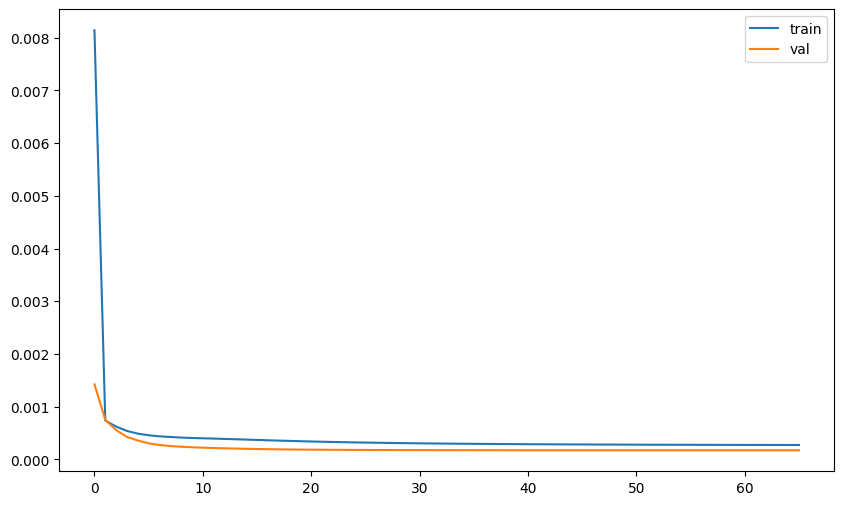

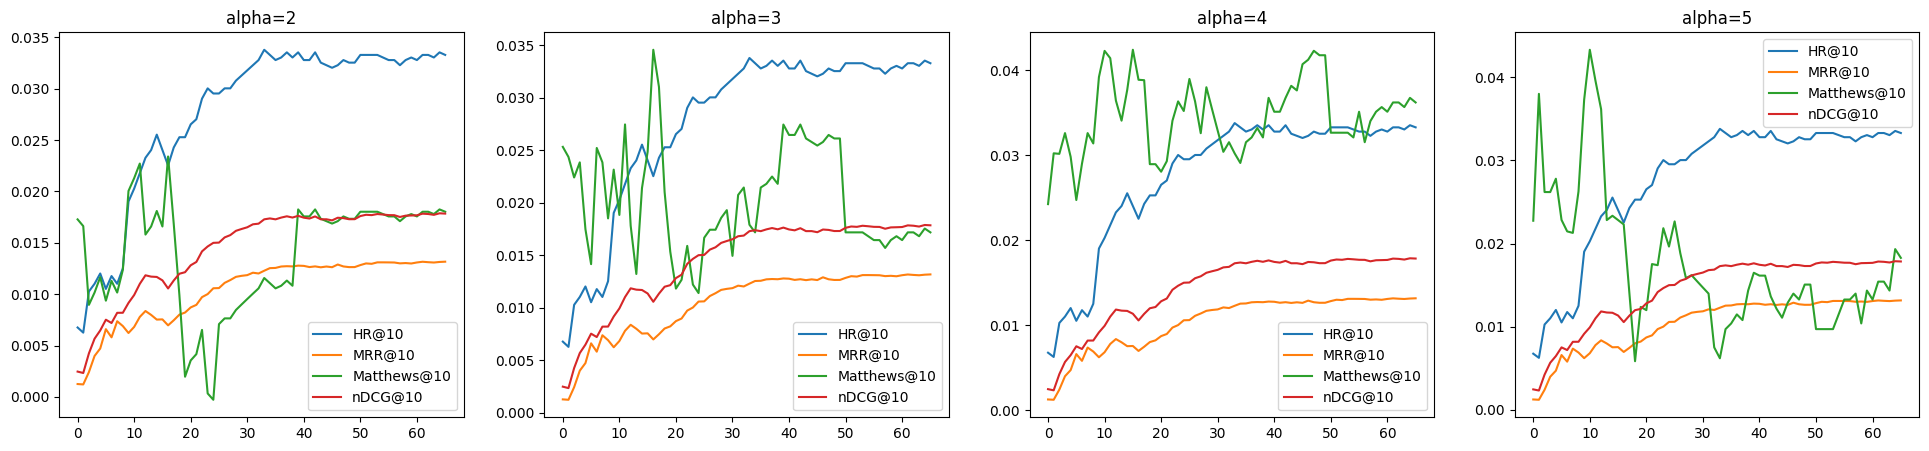

Test loss: 0.00019391544628888369
Train loss: 0.0003631294436668478


Hidden sizes: 32
Current epoch 63
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.018023  0.009366    0.020695  0.011512  0.017772   0.00025   0.009282   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000083    0.011387    0.000125     0.01901

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.030038  0.010897     0.029376  0.015325   0.029537   0.000501   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.010772    0.000125     0.015111     0.000214     0.022258

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.04831  0.012163     0.044418  0.019942   0.046558   0.001752   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.01195    0.000213      0.01941     0.000532     0.006492

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.013767  0.008206    0.005249  0.009571  0.013267  0.000501   0.007906   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5     0.0003    0.009224    0.000347    0.020951

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.023029  0.009412     0.007975  0.012536   0.022528   0.000501   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009112      0.0003     0.012189     0.000347     0.035229

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.038298  0.010402     0.012518  0.016309   0.036546   0.001752   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010029    0.000374     0.015662     0.000647     0.028708

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.013767  0.008206    0.005249  0.009571  0.012766  0.001001   0.007405   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000801    0.008723    0.000848    0.035143

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.023029  0.009412     0.007975  0.012536   0.021777   0.001252   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.00858    0.000832     0.011609     0.000927     0.052871

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.038298  0.010402     0.012518  0.016309   0.034793   0.003504   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009442     0.00096     0.014848     0.001461     0.049792

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.013767  0.008206    0.005249  0.009571  0.010513  0.003254   0.005569   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002637    0.006781    0.002791    0.038114

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.023029  0.009412     0.007975  0.012536   0.017772   0.005257   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006502     0.00291     0.009091     0.003445     0.052074

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.038298  0.010402     0.012518  0.016309   0.027284   0.011014   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007113     0.00329     0.011434     0.004875     0.043458

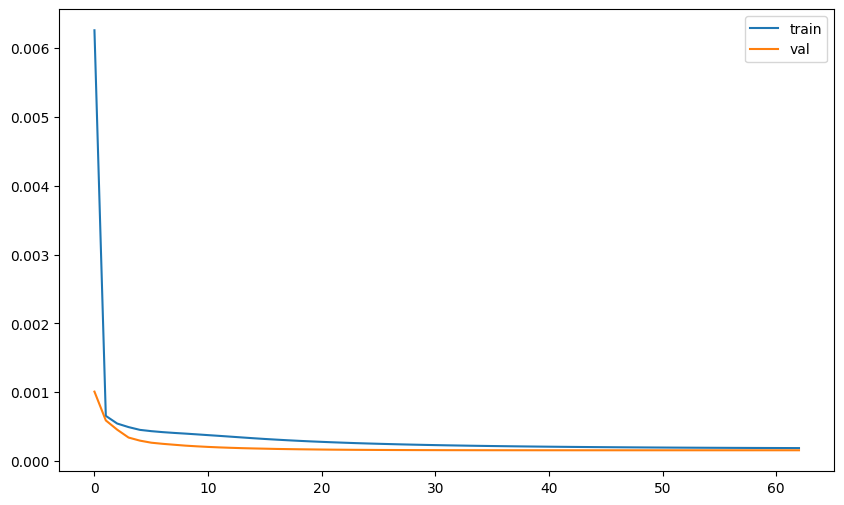

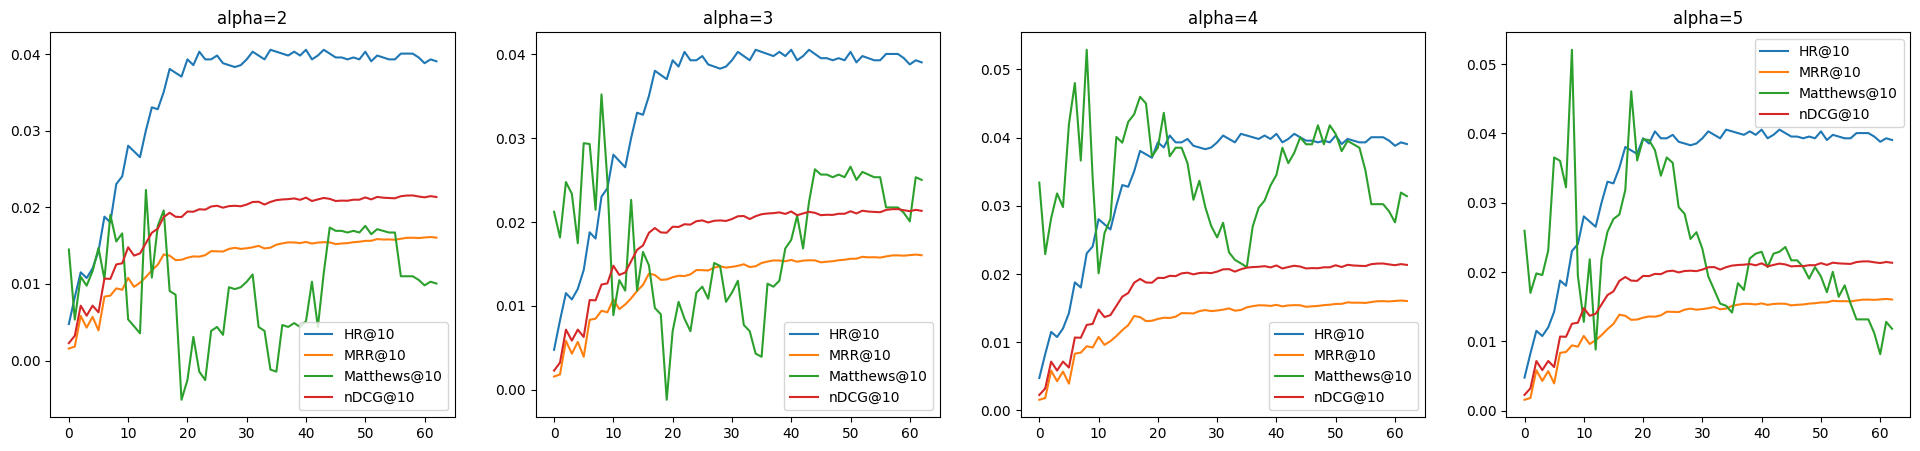

Test loss: 0.00018709369760472327
Train loss: 0.0003425349183353724


Hidden sizes: 64
Current epoch 80
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.039049  0.020071    0.195336  0.024726  0.037547  0.001502   0.019228   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000843     0.02372    0.001006    0.003607

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.058573  0.022668      0.26812  0.031029   0.057071   0.001502   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.021825    0.000843     0.030024     0.001006     0.020396

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.081602  0.024234     0.354634  0.036808   0.078348   0.003254   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.023275    0.000959     0.035366     0.001442     0.003231

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.037797  0.019675    0.226327  0.024129  0.035795  0.002003   0.018582   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001093    0.022808    0.001322    0.023405

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.05582  0.022145     0.307289  0.030022   0.053317   0.002503   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.020975    0.001171     0.028527     0.001494     0.035766

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.081852  0.023929      0.40854  0.036575   0.076846   0.005006   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.022588    0.001341     0.034452     0.002123     0.026551

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.037797  0.020851    0.157682  0.025057  0.033292  0.004506    0.01859   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002261     0.02225    0.002807    0.035436

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.058323  0.023604     0.216334  0.031709   0.051564   0.006758   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.021038    0.002567     0.028169     0.003541     0.046608

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.083605  0.025316      0.28932  0.038048   0.071089   0.012516   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.022339    0.002977     0.033038      0.00501     0.030487

Results for alpha=5


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.033292  0.01829    0.051686  0.022001  0.023529  0.009762   0.013596   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.004693    0.016056    0.005945    0.038267

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.050814  0.020613     0.073895  0.027653   0.036546   0.014268   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10      0.0153    0.005313     0.020233      0.00742     0.053604

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.074593  0.022201     0.106097  0.033588   0.051064   0.023529   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.016252    0.005949     0.023835     0.009753     0.045644

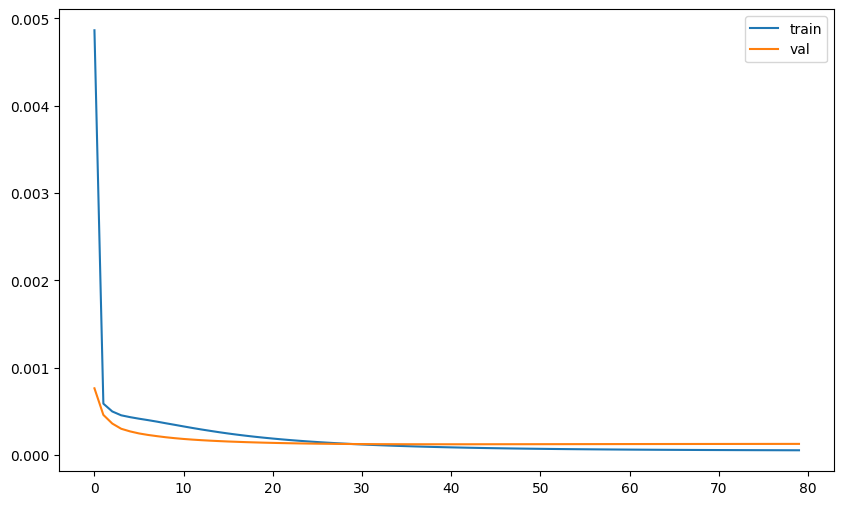

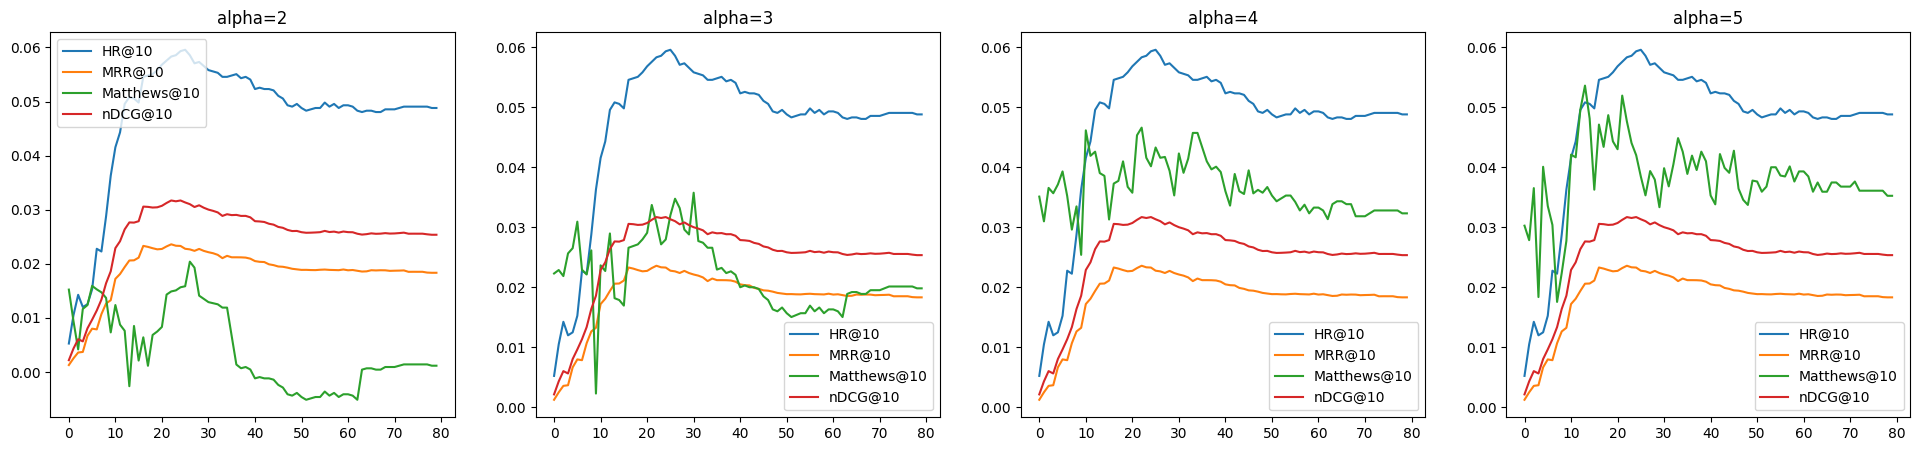

Test loss: 0.00012640206841751933
Train loss: 0.00012180799189060881


Hidden sizes: 128
Current epoch 73
Results for alpha=2


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.0398  0.02242    0.310216  0.026716  0.039549   0.00025   0.022336   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000083    0.026591    0.000125    0.036277

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.061327  0.025284     0.414193  0.03367   0.061076    0.00025   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.025201    0.000083     0.033545     0.000125     0.048356

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.084856  0.026928     0.527155  0.03963   0.083104   0.001752   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.026725    0.000202     0.039108     0.000523     0.032473

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.041302  0.023254    0.320917  0.027696  0.039549  0.001752   0.022507   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000747    0.026703    0.000993    0.032321

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.058073  0.025471     0.431658  0.033099    0.05632   0.001752   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.024724    0.000747     0.032106     0.000993      0.04951

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.084355  0.027327     0.549263  0.039784    0.07985   0.004506   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.026376    0.000951     0.038078     0.001706     0.035376

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.029287  0.017484    0.046134  0.020411  0.026533  0.002753   0.015757   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001727    0.018426    0.001985    0.042225

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.049312  0.020092      0.06703  0.026821   0.045056   0.004255   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.018201    0.001892     0.024387     0.002434     0.059855

HR@20  MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.07234  0.0217     0.094791  0.032655   0.062578   0.009762    0.019439   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.002261     0.028844     0.003811     0.038704

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.029287  0.017484    0.046134  0.020411  0.022778  0.006508   0.013767   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.003717    0.015997    0.004413     0.06106

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.049312  0.020092      0.06703  0.026821   0.035544   0.013767   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.015461    0.004631     0.020115     0.006707      0.05351

HR@20  MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.07234  0.0217     0.094791  0.032655   0.047059   0.025282      0.0163   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20      0.0054     0.023074     0.009581     0.025438

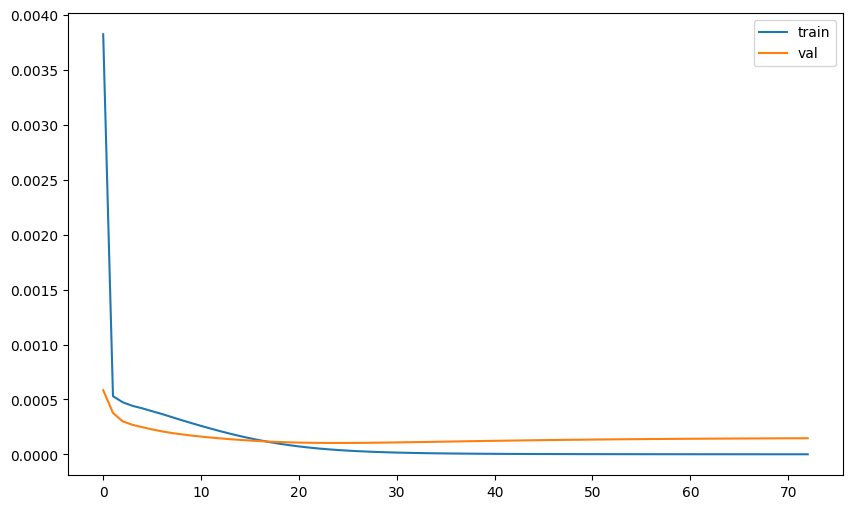

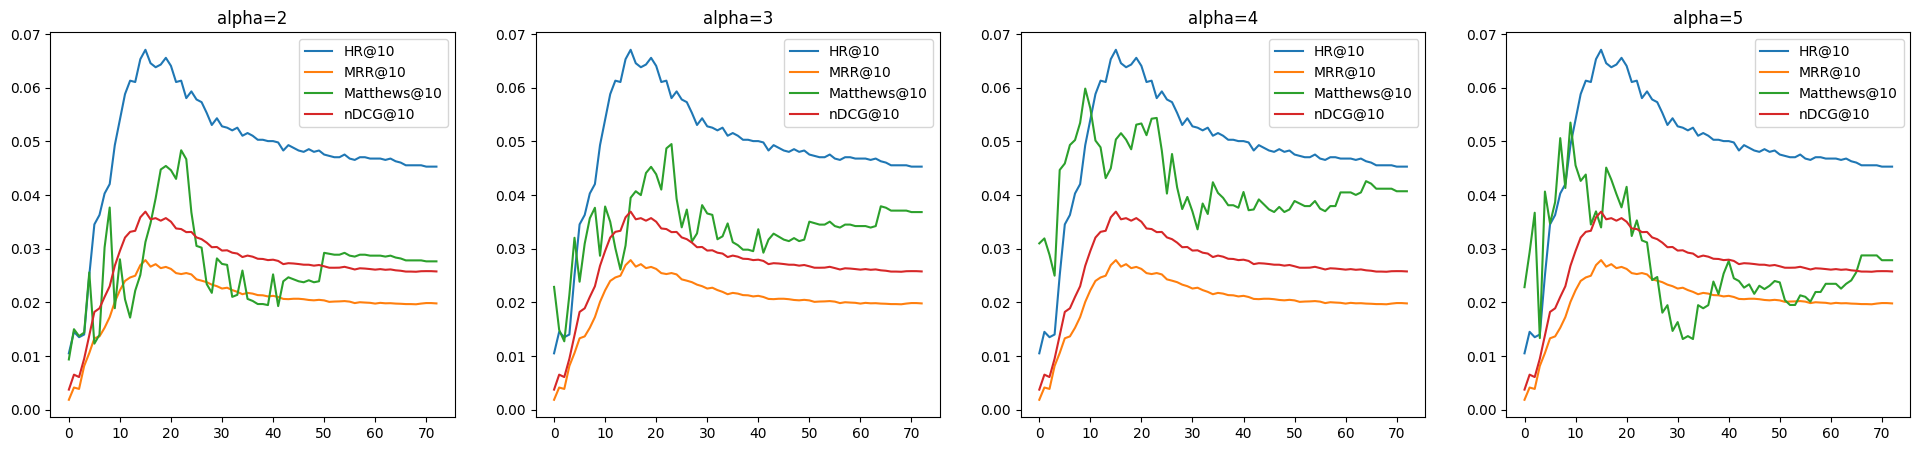

Test loss: 0.00010432064300402999
Train loss: 4.6404496554221486e-05


Hidden sizes: 256
Current epoch 69
Results for alpha=2


HR@5    MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.0398  0.02297     0.41066  0.02712  0.039549   0.00025    0.02292   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00005    0.027023    0.000097    0.036277

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.057071  0.025224     0.540077  0.032651   0.056821    0.00025   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.025174     0.00005     0.032554     0.000097      0.04617

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.082103  0.026913      0.67444  0.038919    0.08035   0.001752   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.026772    0.000141     0.038459      0.00046     0.030862

Results for alpha=3


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.046058  0.02713    0.123763  0.031827  0.044055  0.002003   0.026045   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001085    0.030512    0.001315    0.033391

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.066834  0.029867     0.165354  0.038508    0.06433   0.002503   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.028711    0.001156     0.037026     0.001482     0.046416

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.096871  0.031836     0.222996  0.045959   0.092115   0.004756   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.030527    0.001309     0.043912     0.002047     0.043211

Results for alpha=4


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.046058  0.02713    0.123763  0.031827    0.0403  0.005757   0.023876   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.003254    0.027945    0.003882    0.036035

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.066834  0.029867     0.165354  0.038508   0.058573    0.00826   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.026269    0.003598     0.033807     0.004701     0.044848

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.096871  0.031836     0.222996  0.045959   0.083605   0.013267   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.027922    0.003913     0.040032     0.005927     0.043717

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.026783  0.013897    0.026449  0.017058  0.018273  0.008511   0.009303   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.004593    0.011508     0.00555    0.025882

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.039049  0.015476     0.040178  0.020967   0.027785   0.011264   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.010525    0.004951     0.014537     0.006431     0.043536

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.060576  0.016908      0.05855  0.026331   0.042053   0.018523   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.011476    0.005433     0.018093     0.008238      0.04584

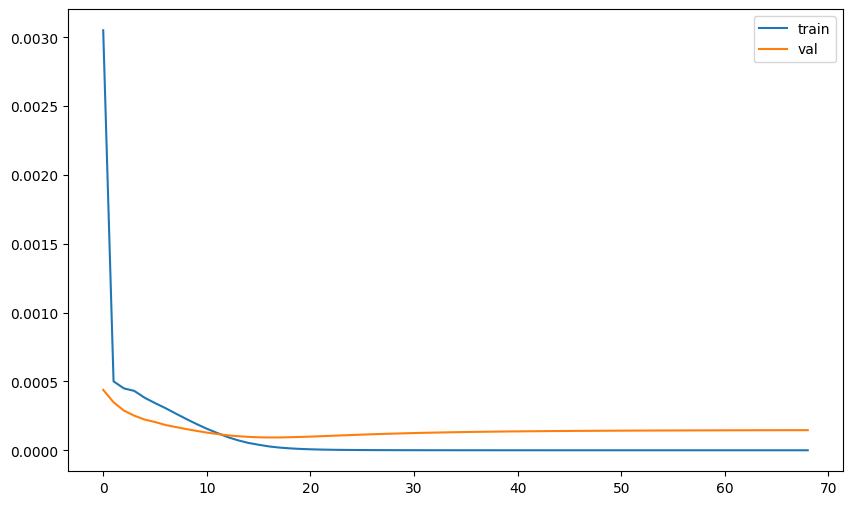

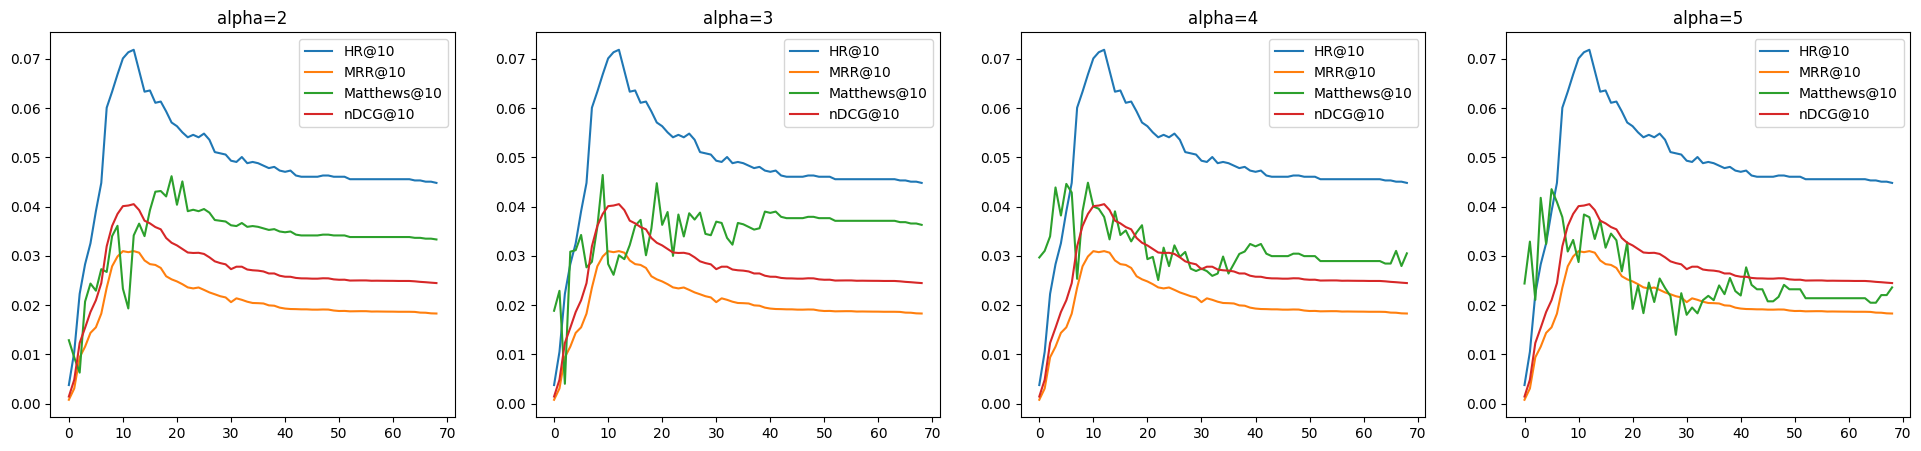

Test loss: 9.697408677311614e-05
Train loss: 1.0057126368217303e-05


Hidden sizes: 512
Current epoch 64
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.019775  0.009604    0.023117  0.012112  0.019775       0.0   0.009604   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.012112         0.0    0.029759

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.032791  0.011289     0.033616  0.016269   0.032541    0.00025   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.011261    0.000028     0.016194     0.000075     0.031575

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.049061  0.012388     0.051686  0.020345   0.048811    0.00025   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.012361    0.000028     0.020269     0.000075     0.041816

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.035544  0.019691    0.369978  0.023607  0.034293  0.001252   0.019065   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000626    0.022823    0.000784    0.034831

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.052566  0.021989     0.502827  0.029136   0.050563   0.002003   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.021258    0.000731     0.028105     0.001032     0.040315

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.075845  0.023634     0.638805  0.03506    0.07209   0.003755   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.022764     0.00087     0.033563     0.001496      0.03738

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.047559  0.025211    0.105694  0.030705  0.041802  0.005757   0.022541   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00267    0.027281    0.003424    0.038898

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.069587  0.028079     0.146073  0.037757   0.061327    0.00826   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.025081    0.002998     0.033529     0.004228     0.049245

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.09612  0.029911     0.198264  0.044451   0.083855   0.012265   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.026636    0.003275     0.039212     0.005239     0.051311

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.047559  0.025211    0.105694  0.030705  0.032791  0.014768   0.018536   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.006675    0.022055     0.00865     0.03817

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.069587  0.028079     0.146073  0.037757   0.047309   0.022278   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.020419     0.00766     0.026696     0.011061     0.041332

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.09612  0.029911     0.198264  0.044451   0.065081   0.031039   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.021657    0.008254     0.031192     0.013258     0.047434

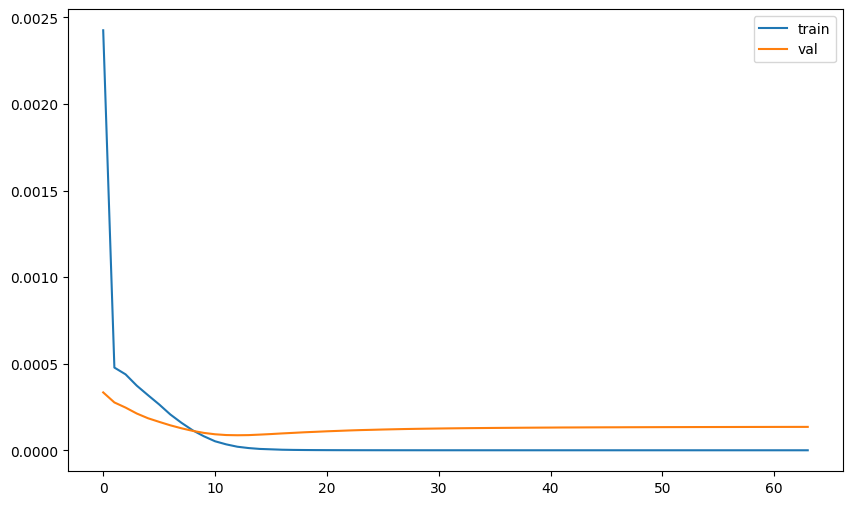

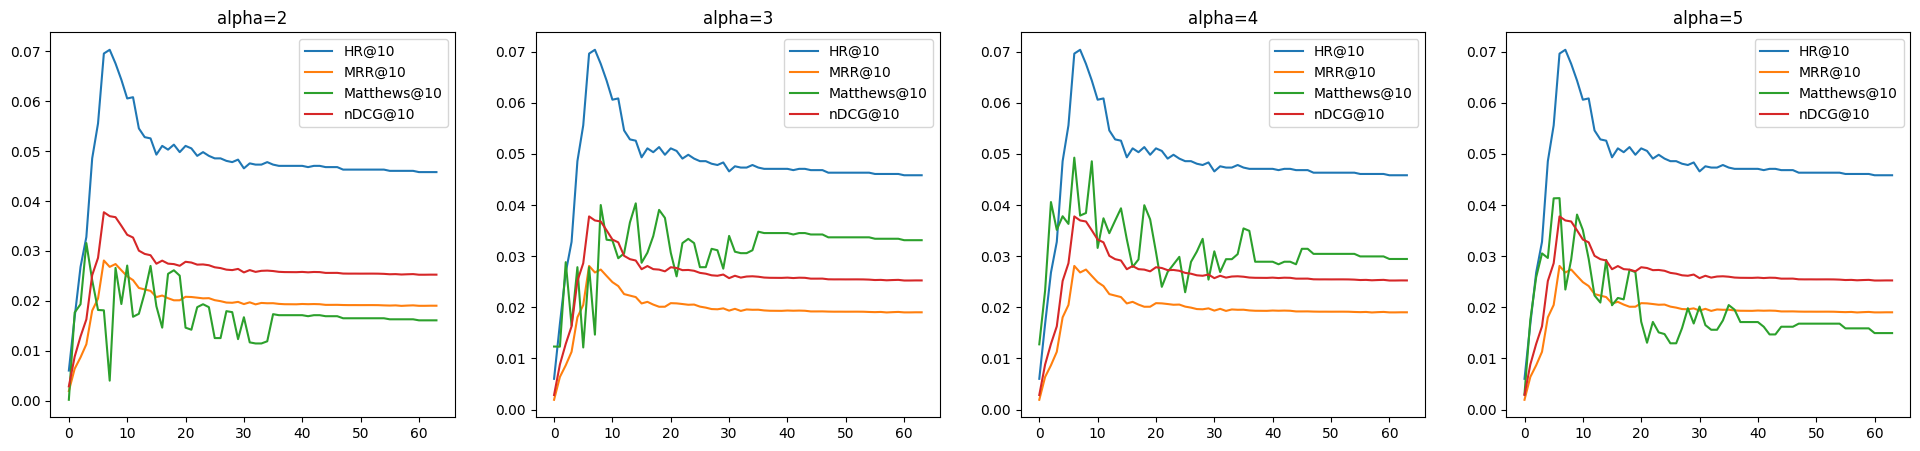

Test loss: 9.054754627868533e-05
Train loss: 7.85870811426705e-06


Hidden sizes: 1024
Current epoch 68
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.039549  0.022582    0.493035  0.026753  0.039049  0.000501    0.02247   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000113    0.026549    0.000205    0.029719

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.05632  0.024799     0.648294  0.032153   0.055569   0.000751   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.024645    0.000154     0.031859     0.000294     0.034956

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.082103  0.02656     0.783061  0.038639    0.07985   0.002253   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.026303    0.000257     0.037966     0.000673     0.021776

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.038548  0.022657    0.420755  0.02659  0.037797  0.000751   0.022399   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000259    0.026211     0.00038    0.047558

HR@10   MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.053567  0.02466     0.566929  0.031447   0.052315   0.001252   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.024345    0.000315     0.030915     0.000531     0.053211

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.0801  0.026479     0.700384  0.038127   0.076596   0.003504    0.026003   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000477     0.037019     0.001107     0.044556

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.038298  0.022833    0.437311  0.026677  0.033542  0.004756   0.020484   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002349     0.02374    0.002937    0.033143

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.057071  0.025308     0.589138  0.032716   0.050563   0.006508   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.022737    0.002571     0.029223     0.003493     0.047233

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.080851  0.026896     0.724006  0.038651   0.070338   0.010513   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.024059    0.002837      0.03416      0.00449     0.044829

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.0403  0.022787    0.482536  0.027088  0.027785  0.012516   0.015991   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.006796     0.01888    0.008209     0.03499

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.055069  0.024756     0.636483  0.031861   0.039299    0.01577   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.017538    0.007217     0.022613     0.009248     0.053174

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.082854  0.026667     0.770846  0.038865   0.054068   0.028786   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.018551    0.008115     0.026333     0.012532      0.02864

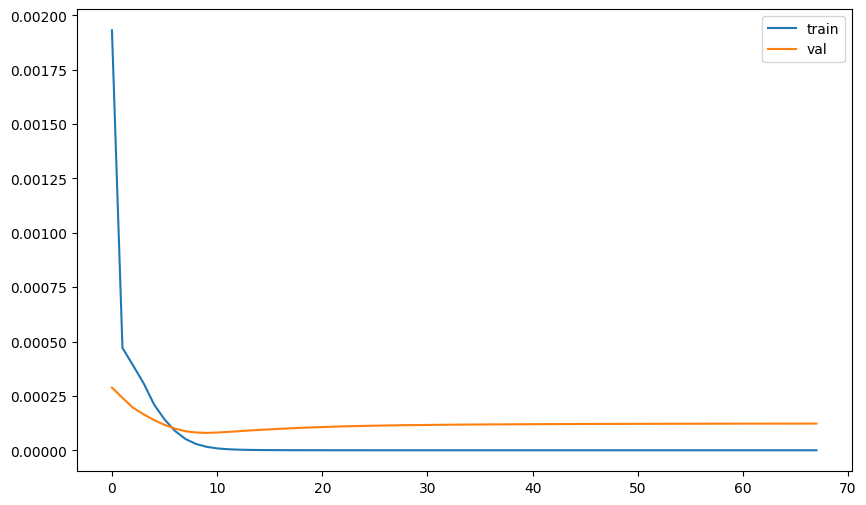

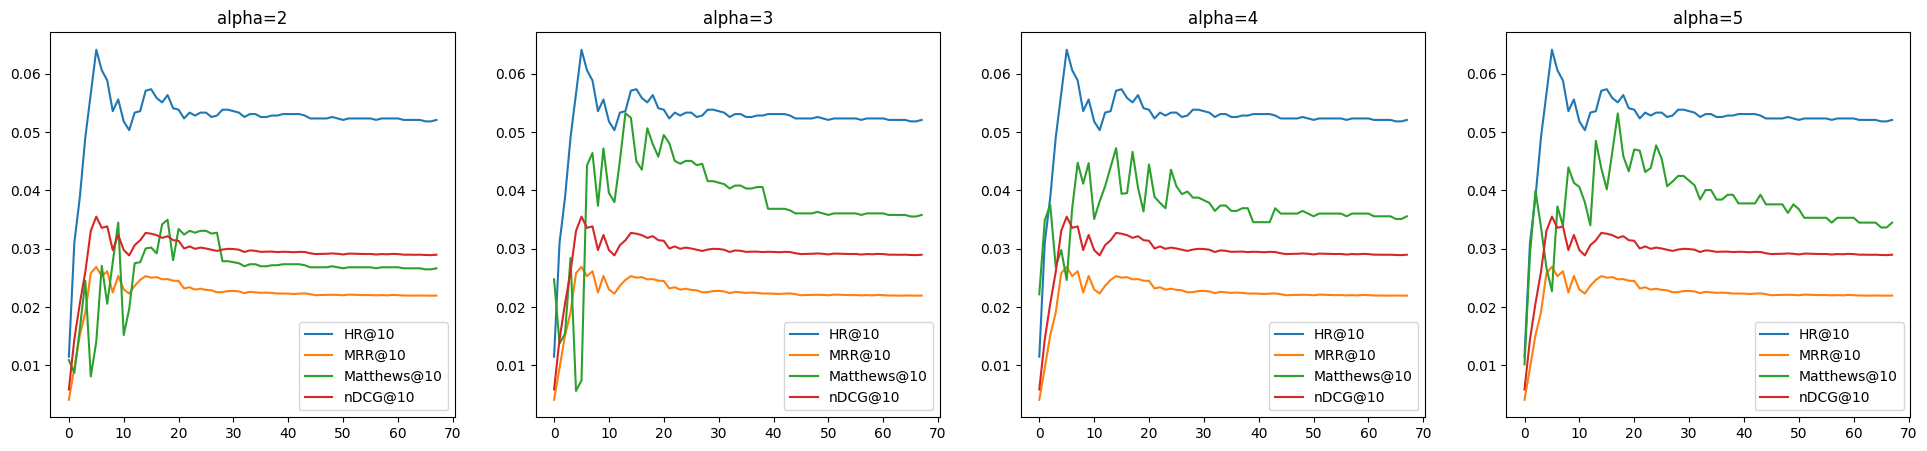

Test loss: 0.00010337485582567751
Train loss: 3.693960902140949e-07


Batch size: 32


  0%|          | 0/7 [00:00<?, ?it/s]

Hidden sizes: 16
Current epoch 71
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.008511  0.006037    0.005047  0.006663   0.00826   0.00025   0.005786   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00025    0.006413     0.00025    0.005835

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.014268  0.006808     0.007066  0.008528   0.014018    0.00025   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006558     0.00025     0.008277      0.00025     0.014691

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.025282  0.007502     0.010095  0.011224   0.024781   0.000501   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007235    0.000267     0.010911     0.000313     0.017854

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.00826  0.006191     0.00424  0.006712   0.00801   0.00025   0.005941   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00025    0.006461     0.00025    0.018155

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013767  0.006961     0.006663  0.008529   0.013517    0.00025   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006711     0.00025     0.008279      0.00025     0.028609

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.025782  0.007731     0.009388  0.011486   0.025031   0.000751   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007443    0.000288     0.011106     0.000381     0.033044

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.00826  0.006191     0.00424  0.006712  0.007509  0.000751   0.005565   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000626    0.006053    0.000659     0.02291

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013767  0.006961     0.006663  0.008529   0.012766   0.001001   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006299    0.000662     0.007787     0.000742     0.035143

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.025782  0.007731     0.009388  0.011486   0.023529   0.002253   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.006981     0.00075     0.010426      0.00106     0.042304

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.002753  0.001068    0.000808  0.001473  0.002003  0.000751   0.000705   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000363    0.001018    0.000455     0.01304

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.010513  0.002215      0.00212  0.004092    0.00801   0.002503   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001577    0.000638      0.00303     0.001062     0.032886

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.01627  0.002604     0.003634  0.005536   0.012015   0.004255   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.001853    0.000751     0.004041     0.001495     0.034861

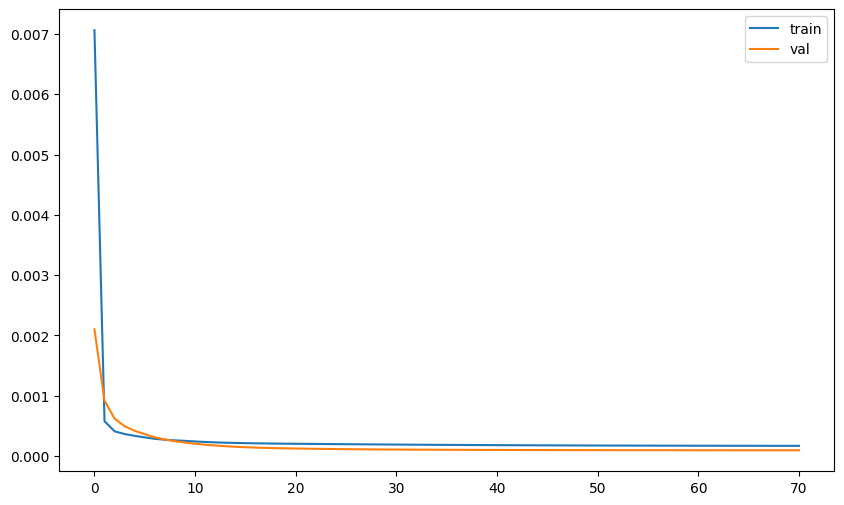

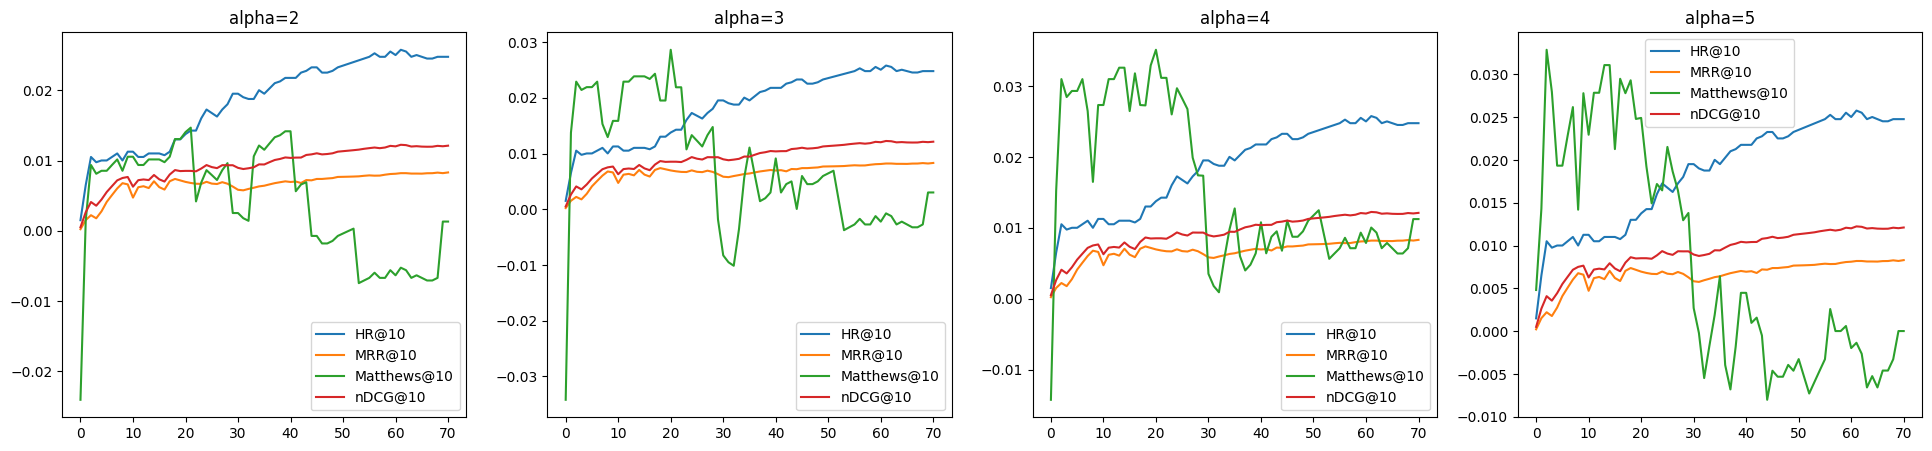

Test loss: 0.00011908483429579064
Train loss: 0.00019885944823612653


Hidden sizes: 32
Current epoch 67
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.001502  0.000759    0.000707  0.000946  0.001502       0.0   0.000759   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000946         0.0    0.008126

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.00826  0.001531      0.00212    0.003    0.00826        0.0    0.001531   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10         0.0        0.003          0.0     0.019122

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.015269  0.002045     0.003331  0.004806   0.015019    0.00025   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.002025    0.000019     0.004741     0.000066     0.015919

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.00826  0.004272    0.002019  0.005269   0.00801   0.00025   0.004147   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000125    0.005112    0.000158    0.018155

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013517  0.004901      0.00535  0.006896   0.013267    0.00025   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.004776    0.000125     0.006738     0.000158     0.028203

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.026533  0.005755      0.00747  0.010126   0.025532   0.001001   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.005578    0.000176     0.009779     0.000347     0.028468

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010013  0.007397    0.004644  0.008033  0.009262  0.000751   0.006646   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000751    0.007282    0.000751     0.02933

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.018023  0.008405     0.007066  0.010563   0.017021   0.001001   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007629    0.000776      0.00974     0.000823     0.046236

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03204  0.009406     0.010095  0.014142   0.029537   0.002503   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008523    0.000882     0.012936     0.001205     0.051609

Results for alpha=5


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011514  0.00761    0.006259  0.008577   0.00776  0.003755   0.004877   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002733    0.005585    0.002992    0.014999

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.021527  0.008896     0.009186  0.011767    0.01602   0.005507   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.005938    0.002958     0.008217      0.00355     0.041944

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.035544  0.009903     0.013628  0.015354   0.024531   0.011014   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.006564    0.003339     0.010413     0.004942     0.033054

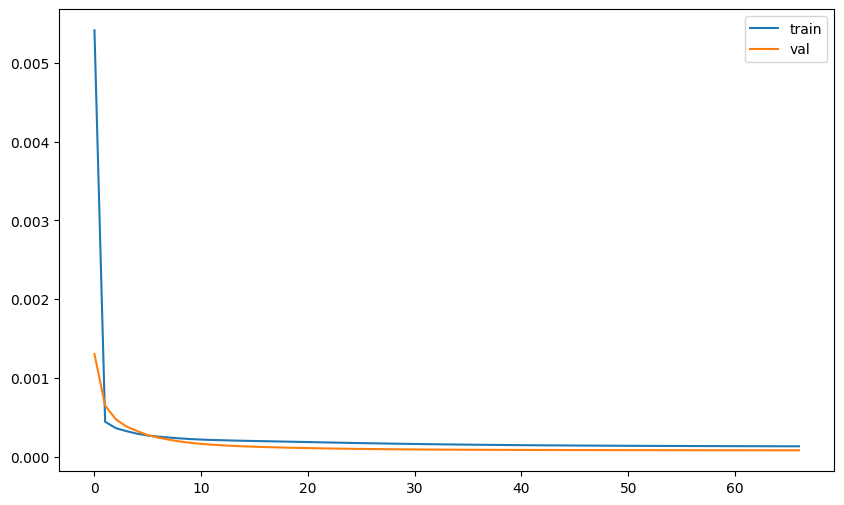

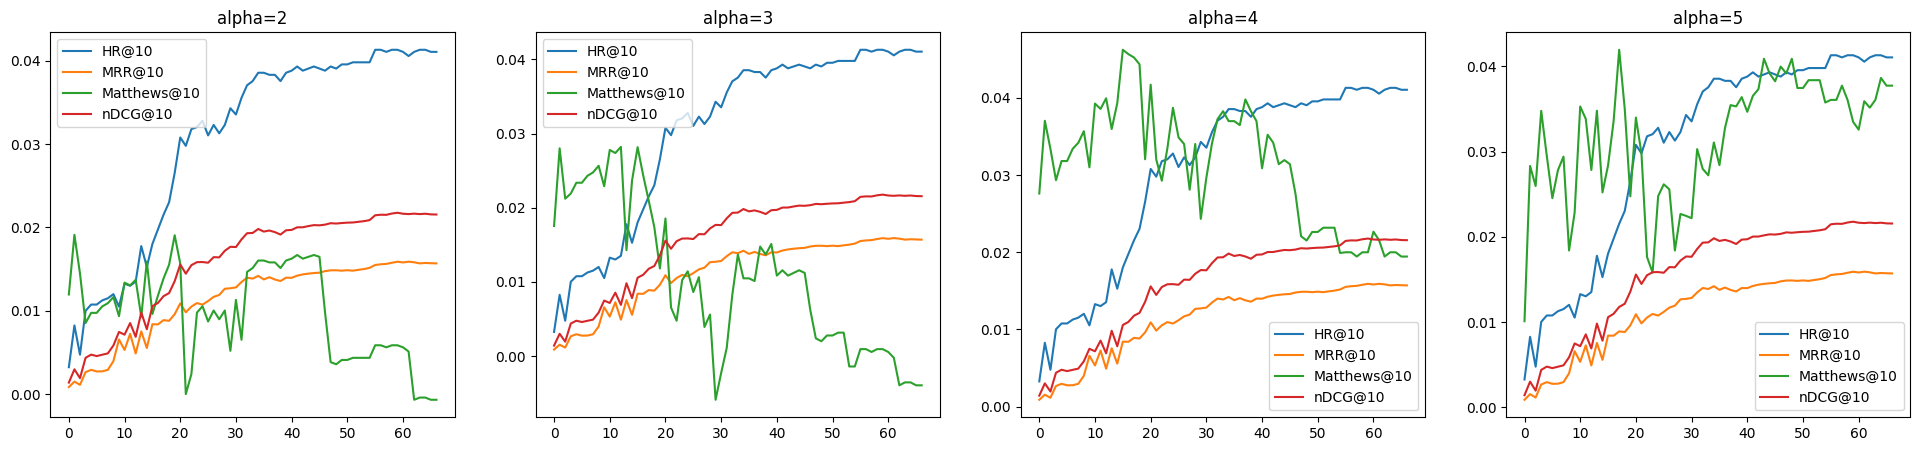

Test loss: 0.00011991451901849359
Train loss: 0.00019523682224560152


Hidden sizes: 64
Current epoch 103
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.01602  0.009366    0.008884  0.010994   0.01577   0.00025   0.009116   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00025    0.010744     0.00025    0.016801

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.027534  0.010863     0.012417  0.014677   0.027284    0.00025   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.010612     0.00025     0.014427      0.00025     0.027634

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.043304  0.011947     0.018575  0.018653   0.041552   0.001752   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.011596    0.000351     0.018027     0.000626     0.001686

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.036295  0.021648    0.127196  0.02527  0.035044  0.001252   0.020584   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001064    0.024161    0.001109    0.035714

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.05607  0.024163     0.173632  0.03154   0.053317   0.002753    0.022895   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001267     0.029942     0.001598     0.032147

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.084355  0.026169      0.23299  0.038746   0.078598   0.005757   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.024665    0.001504     0.036353     0.002393     0.019323

Results for alpha=4


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.036295  0.021648    0.127196  0.02527  0.032791  0.003504   0.019554   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002094    0.022831    0.002438    0.045921

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.05607  0.024163     0.173632  0.03154   0.049812   0.006258     0.02172   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002443      0.02823      0.00331     0.048303

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.084355  0.026169      0.23299  0.038746   0.070088   0.014268   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.023146    0.003023     0.033381     0.005365     0.015573

Results for alpha=5


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.027034  0.01587    0.033919  0.018623  0.019024   0.00801   0.011723   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.004147    0.013517    0.005106    0.033327

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.046558  0.018499      0.04896  0.024961   0.033542   0.013016   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.013699      0.0048     0.018251      0.00671     0.051746

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.071089  0.020155     0.072078  0.031105    0.04781   0.023279   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.014628    0.005527     0.021782     0.009324     0.037665

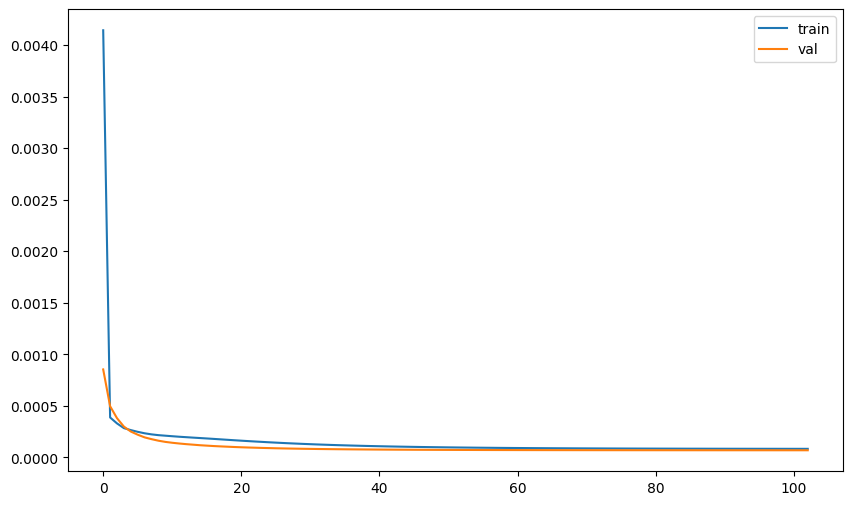

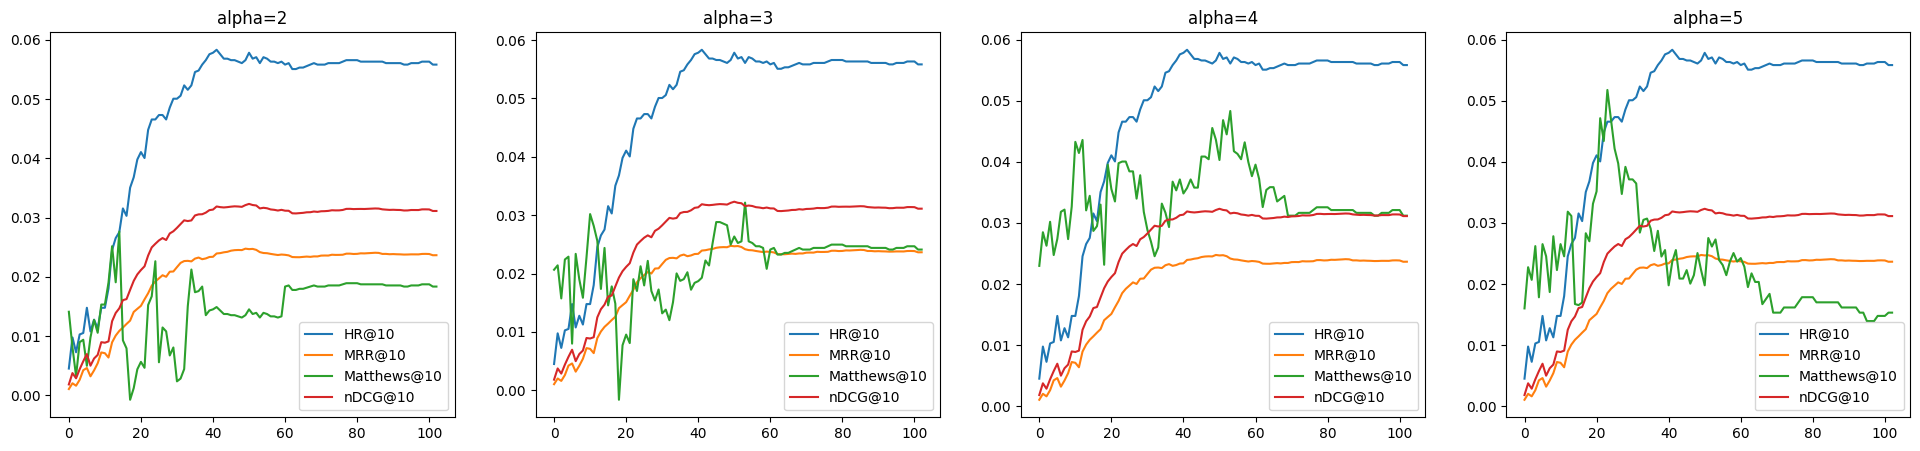

Test loss: 7.194648787844926e-05
Train loss: 9.488711569268105e-05


Hidden sizes: 128
Current epoch 108
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.0398  0.022157    0.078841  0.026492  0.039049  0.000751   0.021961   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000196    0.026162     0.00033    0.023518

HR@10   MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.059074  0.02468     0.109731  0.032677   0.058323   0.000751   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.024484    0.000196     0.032347      0.00033     0.036629

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.092115  0.02691     0.149001  0.040953   0.089362   0.002753   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.026572    0.000338     0.040113      0.00084       0.0193

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.043554  0.024318     0.10852  0.029063  0.041302  0.002253    0.02287   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001448    0.027416    0.001647    0.026156

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.064831  0.027072     0.146073  0.035857   0.062078   0.002753   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.025563    0.001508     0.034054     0.001803     0.040957

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.097872  0.029324     0.196548  0.04416   0.092365   0.005507   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.027626    0.001698     0.041663     0.002497     0.035039

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.043554  0.024318     0.10852  0.029063  0.037797  0.005757   0.020893   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.003425    0.025064    0.003999    0.031082

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.064831  0.027072     0.146073  0.035857   0.057822   0.007009   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.023483    0.003589     0.031456     0.004401     0.054534

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.097872  0.029324     0.196548  0.04416   0.084606   0.013267   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.025302    0.004022     0.038177     0.005983     0.045145

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.043304  0.023846    0.275792  0.028684  0.031289  0.012015    0.01763   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.006216    0.021021    0.007663     0.05074

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.059574  0.025907     0.358672  0.033833   0.043304    0.01627   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.019129    0.006778     0.024802     0.009032     0.062266

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.088611  0.027915     0.459015  0.041167   0.059574   0.029036   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.020245     0.00767     0.028899     0.012268     0.042314

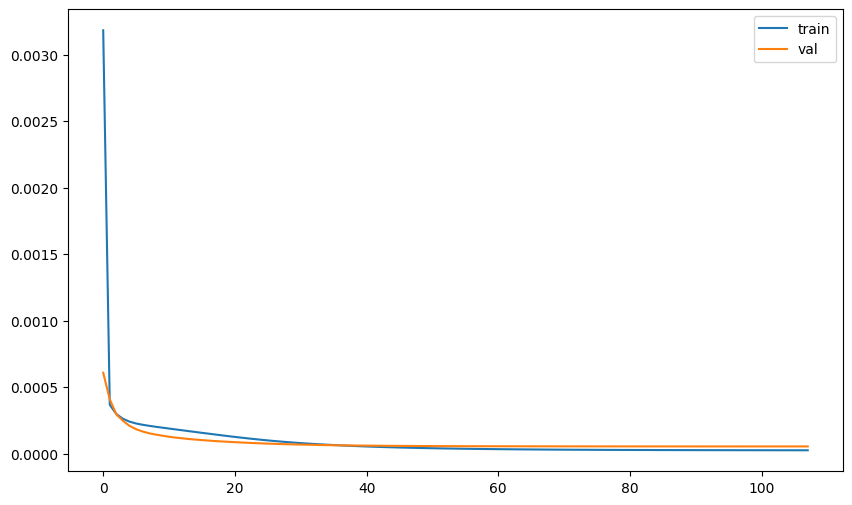

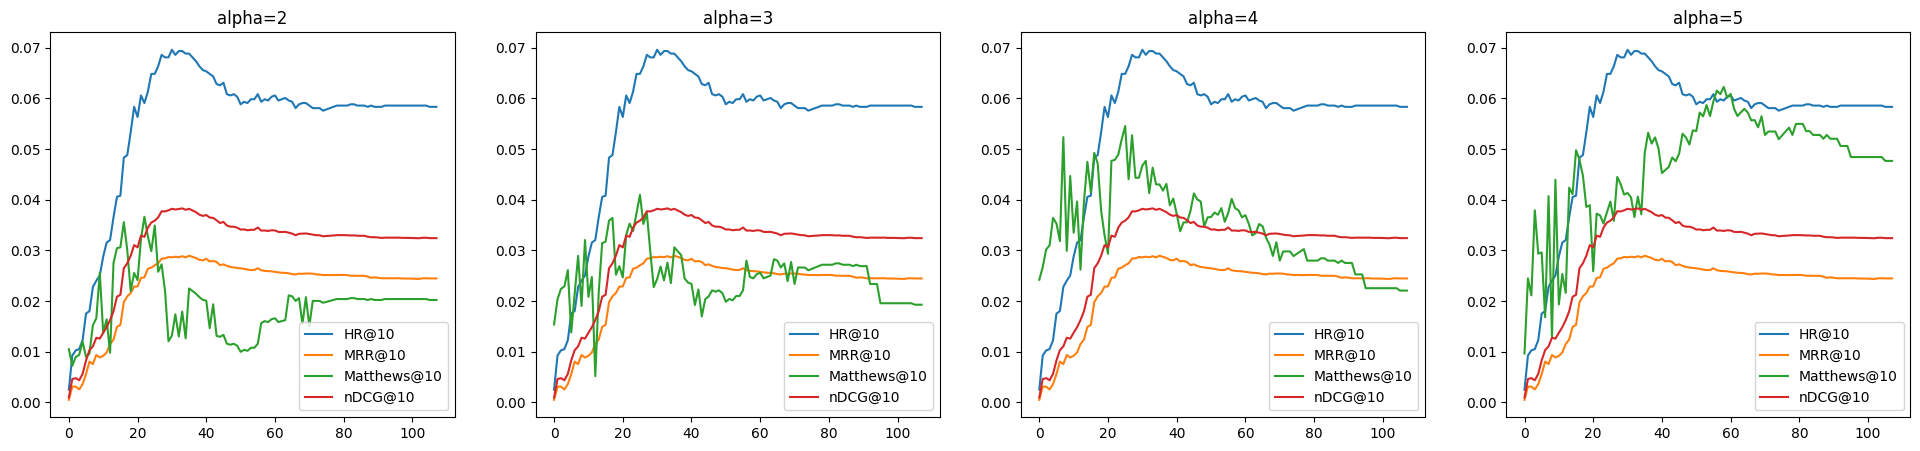

Test loss: 5.5521140893688425e-05
Train loss: 3.4647326579111744e-05


Hidden sizes: 256
Current epoch 90
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.037547  0.020438    0.396729  0.024694  0.037547       0.0   0.020438   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.024694         0.0    0.041383

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.056571  0.022911     0.513123  0.03078   0.056571        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.022911         0.0      0.03078          0.0     0.051306

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.083855  0.024769     0.635574  0.037635   0.081352   0.002503   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.024598     0.00017     0.037007     0.000629     0.018392

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.037547  0.020438    0.396729  0.024694  0.036045  0.001502   0.019729   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000709    0.023787    0.000907    0.032464

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.056571  0.022911     0.513123  0.03078   0.054568   0.002003   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.022145    0.000766     0.029721     0.001058     0.044265

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.083855  0.024769     0.635574  0.037635   0.078598   0.005257   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.023781    0.000987     0.035759     0.001876     0.025259

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.027534  0.014293    0.026953  0.017531  0.024531  0.003004   0.012975   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001318    0.015801    0.001731     0.03443

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.044305  0.016547     0.036644  0.02297     0.0398   0.004506   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.015007     0.00154     0.020733     0.002238     0.048121

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.066834  0.018102      0.05532  0.028656   0.059324   0.007509   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.016349    0.001754     0.025652     0.003004     0.052525

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.030788  0.017209    0.043812  0.020553  0.021777  0.009011   0.012086   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.005123    0.014466    0.006087    0.036953

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.045056  0.019125     0.063396  0.025177    0.03204   0.013016   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.013472    0.005653       0.0178     0.007378     0.046722

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.068836  0.020757      0.08722  0.03117   0.045056    0.02378   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.01436    0.006397     0.021073     0.010096     0.027008

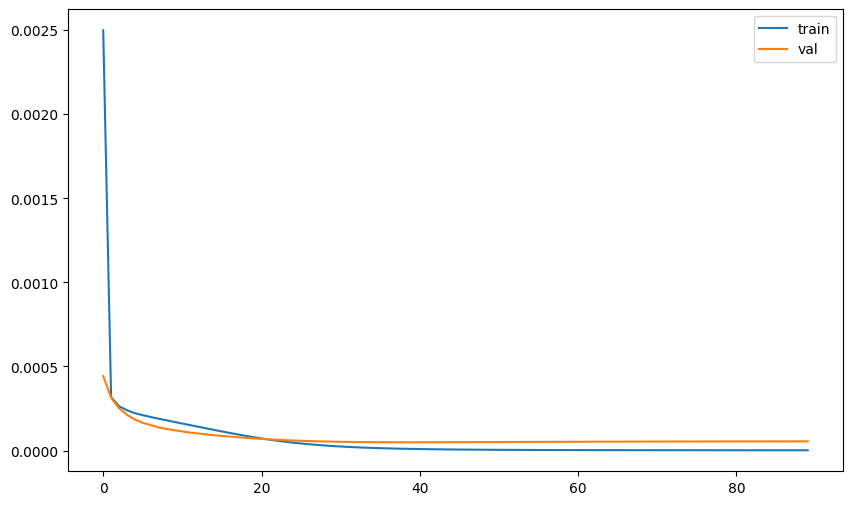

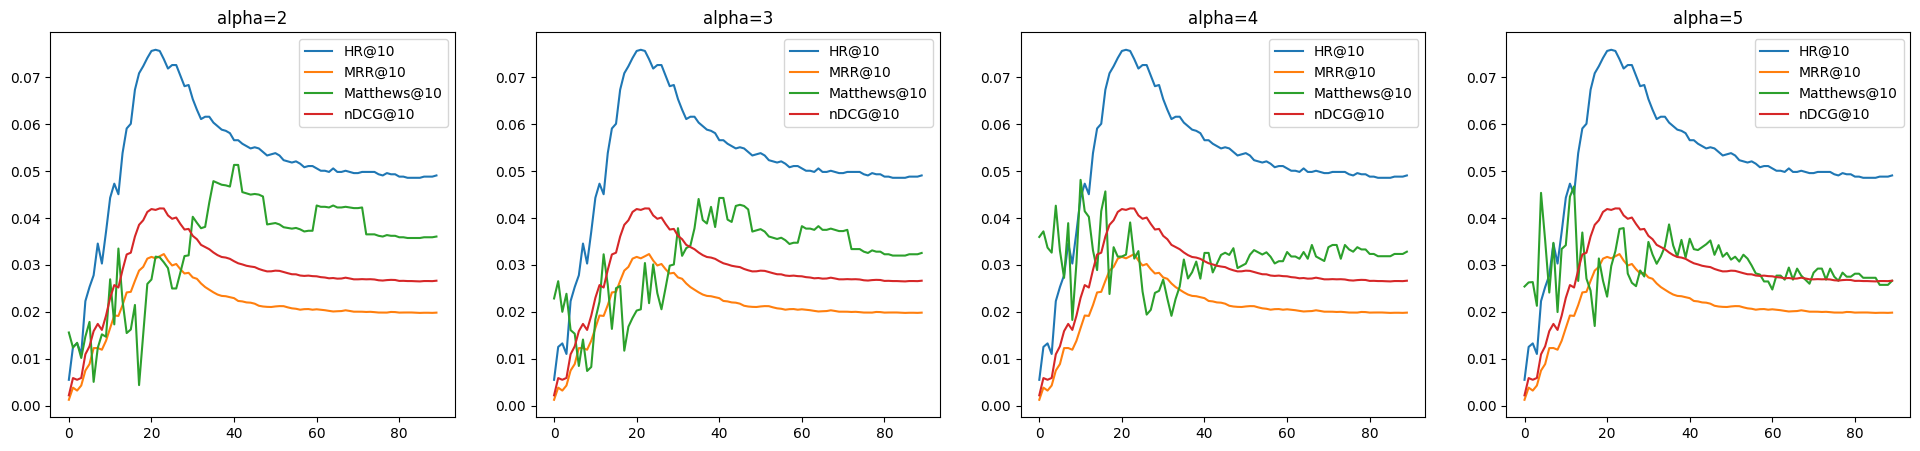

Test loss: 4.9218477215617895e-05
Train loss: 8.833111190704959e-06


Hidden sizes: 512
Current epoch 79
Results for alpha=2


HR@5    MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.043304  0.02501     0.38189  0.02954  0.042553  0.000751    0.02476   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00025    0.029166    0.000374    0.026195

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.063079  0.027671     0.502625  0.035956   0.062078   0.001001   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.027379    0.000292     0.035494     0.000463     0.033844

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.090613  0.029546     0.630123  0.042872   0.087359   0.003254   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.029097    0.000449      0.04184     0.001033     0.009658

Results for alpha=3


HR@5    MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.043304  0.02501     0.38189  0.02954  0.041552  0.001752   0.024197   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000814    0.028492    0.001048    0.034618

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.063079  0.027671     0.502625  0.035956   0.060576   0.002503   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.026749    0.000922     0.034658     0.001298     0.042941

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.090613  0.029546     0.630123  0.042872   0.084856   0.005757   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.028397    0.001149      0.04075     0.002122     0.025399

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.035044  0.021106    0.046941  0.024529  0.031289  0.003755   0.018415   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002691    0.021569     0.00296     0.03994

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.054568  0.023658     0.066626  0.030792    0.04806   0.006508   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.020628     0.00303      0.02697     0.003822     0.042916

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.081852  0.025494      0.09146  0.037616   0.069837   0.012015   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.02212    0.003373     0.032451     0.005166     0.032357

Results for alpha=5


HR@5    MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.038548  0.02146    0.442459  0.02568  0.027034  0.011514   0.014935   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.006525     0.01793     0.00775    0.039049

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.059324  0.024176     0.575308  0.032342   0.040801   0.018523   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.016701    0.007476     0.022311     0.010031     0.042018

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.083605  0.025883     0.702604  0.038509   0.055569   0.028035   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.017726    0.008157     0.026046     0.012463     0.036262

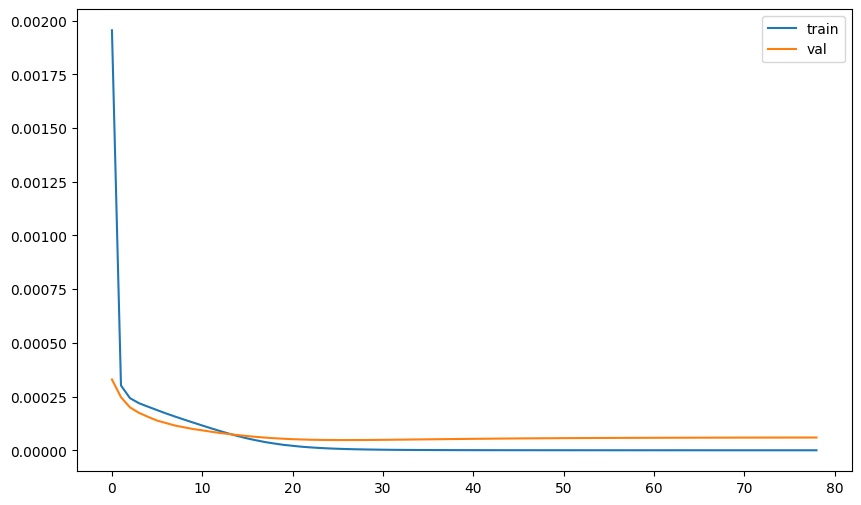

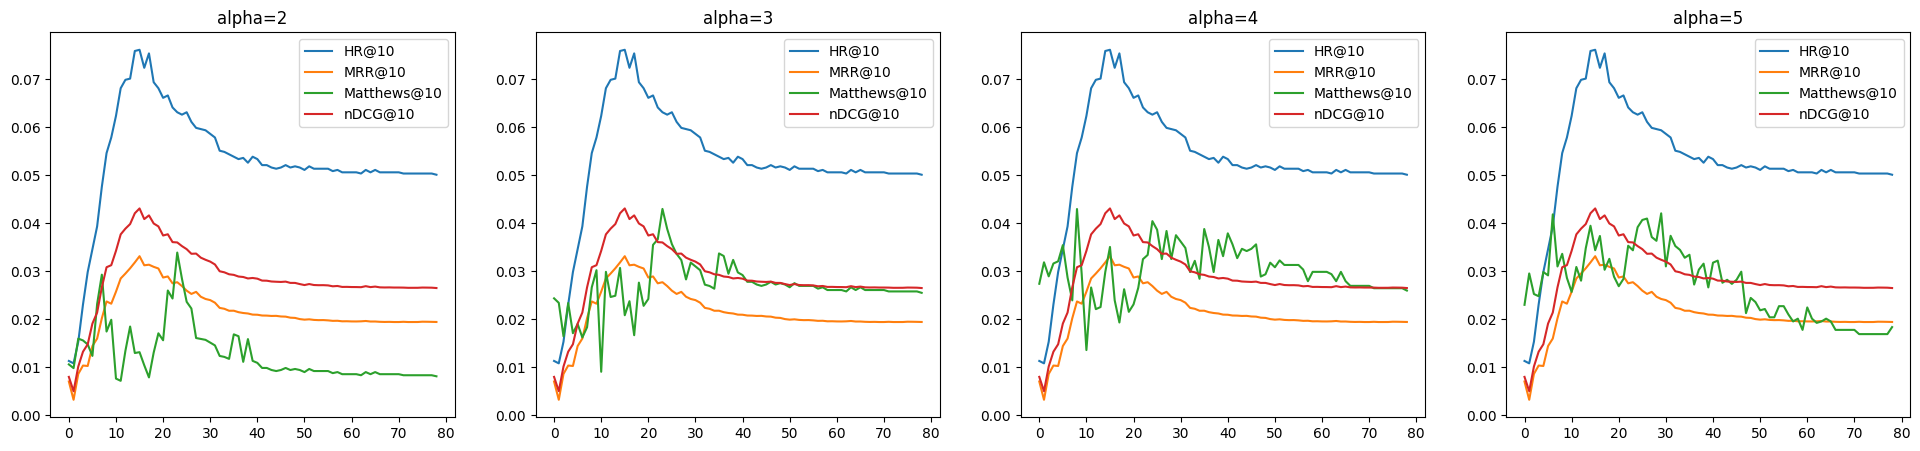

Test loss: 4.842967609874904e-05
Train loss: 3.3854934571028424e-06


Hidden sizes: 1024
Current epoch 58
Results for alpha=2


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.0398  0.02315    0.070866  0.027272  0.039049  0.000751   0.022879   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000271    0.026881    0.000391    0.023518

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.062078  0.026061     0.097517  0.034414   0.060576   0.001502   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.025704    0.000357     0.033795     0.000619     0.022892

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.087109  0.02768     0.133354  0.040595   0.084856   0.002253   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.027281      0.0004     0.039798     0.000797     0.024918

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.047309  0.025811    0.129215  0.031114  0.043805  0.003504   0.024063   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001748    0.028937    0.002177    0.009559

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.068836  0.028692     0.173632  0.038083   0.064831   0.004005   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.026889    0.001804     0.035756     0.002328     0.027067

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.096621  0.030572      0.22976  0.045047   0.090113   0.006508   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.028603    0.001968     0.042098     0.002949     0.021859

Results for alpha=4


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.0398  0.02315    0.070866  0.027272  0.035294  0.004506   0.019887   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.003262    0.023699    0.003572    0.039517

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.062078  0.026061     0.097517  0.034414   0.055069   0.007009   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.022433    0.003628         0.03     0.004413     0.050136

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.087109  0.02768     0.133354  0.040595   0.075845   0.011264   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.023783    0.003897     0.035139     0.005456     0.047259

Results for alpha=5


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.0398  0.02315    0.070866  0.027272  0.027034  0.012766   0.015528   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.007622    0.018384    0.008888    0.030515

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.062078  0.026061     0.097517  0.034414   0.042303   0.019775   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.017489    0.008572     0.023246     0.011168     0.039722

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.087109  0.02768     0.133354  0.040595   0.056571   0.030538   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.018408    0.009273     0.026762     0.013833     0.027448

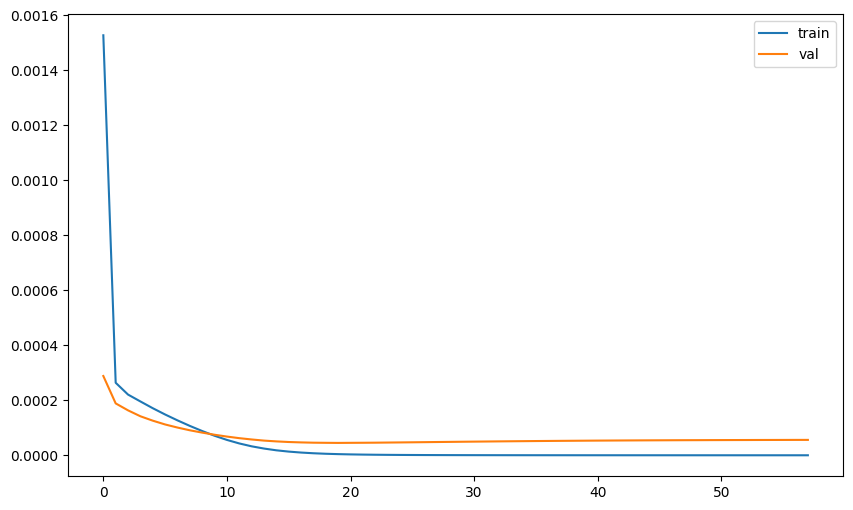

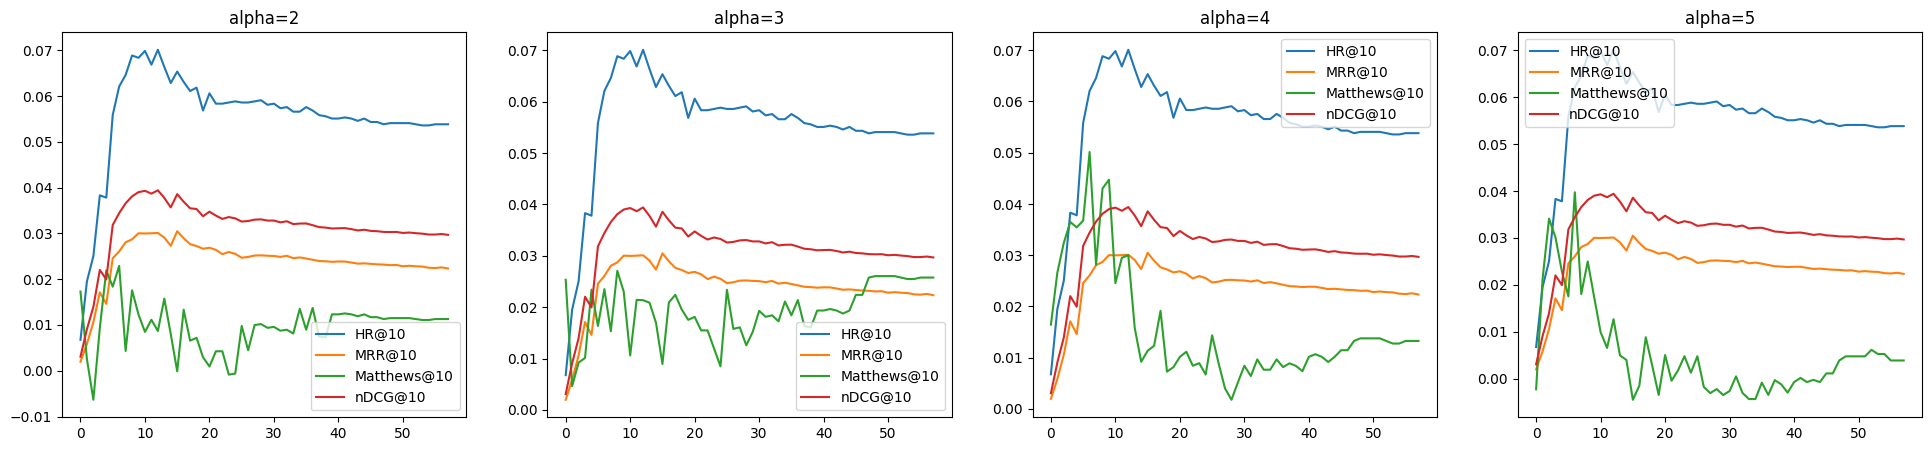

Test loss: 8.248837548308074e-05
Train loss: 8.828503001689544e-05


Batch size: 64


  0%|          | 0/7 [00:00<?, ?it/s]

Hidden sizes: 16
Current epoch 133
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.001502  0.000668    0.001009  0.000874  0.001502       0.0   0.000668   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000874         0.0    0.008126

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.00776  0.001414     0.002221  0.002809    0.00776        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001414         0.0     0.002809          0.0     0.018528

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.015019  0.001932     0.004038  0.004662   0.014768    0.00025   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.001909    0.000023     0.004592      0.00007     0.015618

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.001502  0.000668    0.001009  0.000874  0.001502       0.0   0.000668   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000874         0.0    0.011905

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.00776  0.001414     0.002221  0.002809    0.00776        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001414         0.0     0.002809          0.0     0.027145

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.015019  0.001932     0.004038  0.004662   0.014768    0.00025   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.001909    0.000023     0.004592      0.00007     0.030567

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009011  0.006612     0.00424  0.007204   0.00826  0.000751   0.005861   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000751    0.006453    0.000751    0.025782

HR@10   MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.01577  0.00745     0.006259  0.009326   0.014768   0.001001    0.006658   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000793     0.008486      0.00084     0.040635

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.026283  0.008102     0.008379  0.011886    0.02403   0.002253   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007237    0.000865     0.010748     0.001138     0.043421

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009762  0.006479    0.005148  0.007294  0.006508  0.003254   0.004343   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002136    0.004881    0.002413    0.012326

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.01577  0.007217     0.006764  0.009174   0.012015   0.003755   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.005018    0.002199     0.006603     0.002571     0.040385

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.028035  0.008015     0.010095  0.012209   0.020275    0.00776   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.005559    0.002456     0.008652     0.003558     0.040738

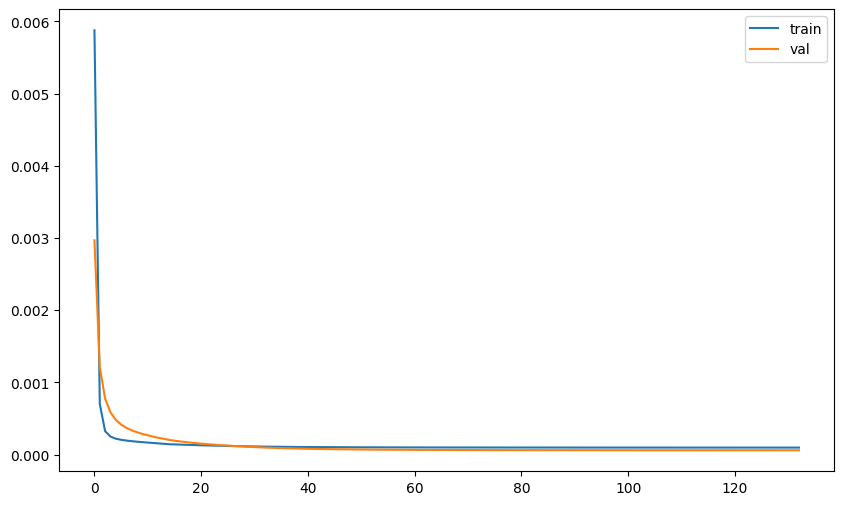

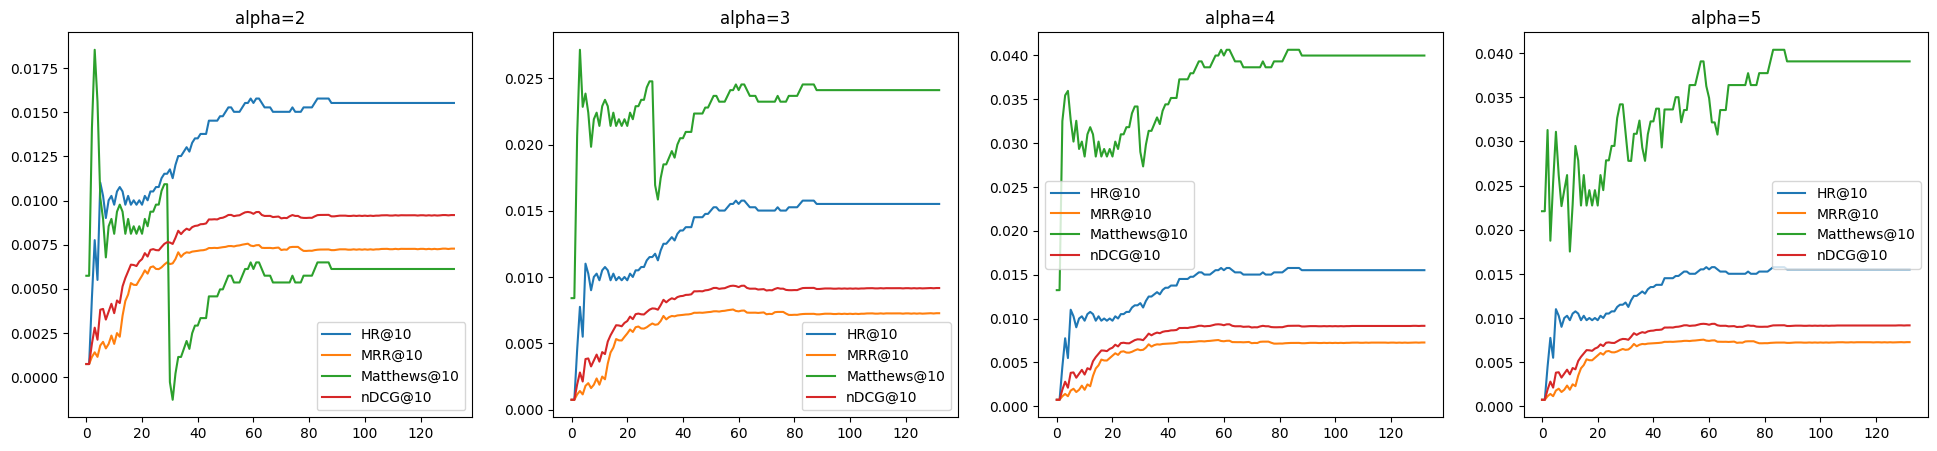

Test loss: 6.206986290635541e-05
Train loss: 9.863453181682614e-05


Hidden sizes: 32


C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))


Current epoch 109
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.01577  0.008665    0.007975  0.010406  0.015519   0.00025    0.00854   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000125    0.010248    0.000158     0.01651

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.025282  0.009947     0.011407  0.013494   0.025031    0.00025   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009822    0.000125     0.013336     0.000158     0.025799

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.037547  0.010791     0.018373  0.016585   0.036295   0.001252   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010596    0.000194     0.016174      0.00041      0.00858

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.01577  0.008665    0.007975  0.010406  0.015269  0.000501   0.008456   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000209    0.010123    0.000283    0.024529

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.025282  0.009947     0.011407  0.013494   0.024531   0.000751   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009697     0.00025     0.013122     0.000372     0.032382

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.037547  0.010791     0.018373  0.016585   0.034793   0.002753   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010404    0.000386      0.01571     0.000875     0.008994

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.013517  0.007831    0.006057  0.009216  0.012766  0.000751    0.00733   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000501     0.00865    0.000566     0.03995

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.020526  0.008707     0.008076  0.011423   0.019024   0.001502   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008098    0.000609     0.010606     0.000818     0.042895

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03179  0.009463     0.012417  0.014241   0.028035   0.003755   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008706    0.000758     0.012863     0.001378     0.032903

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.014018  0.008269    0.007167  0.009681  0.009762  0.004255   0.005686   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002582    0.006688    0.002993    0.022064

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.022778  0.009421     0.009893  0.012498   0.016771   0.006008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006608    0.002814      0.00894     0.003558     0.040699

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.035795  0.010326     0.015243  0.01579    0.02428   0.011514   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007132    0.003193     0.010843     0.004946     0.028514

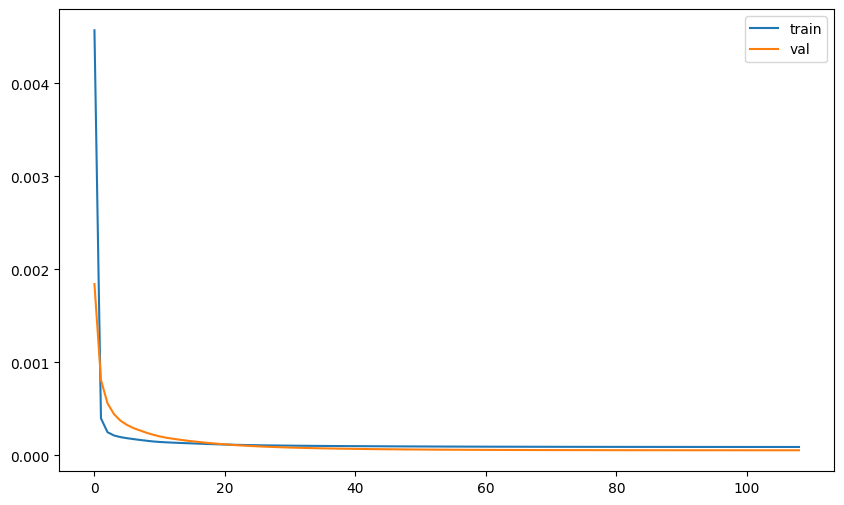

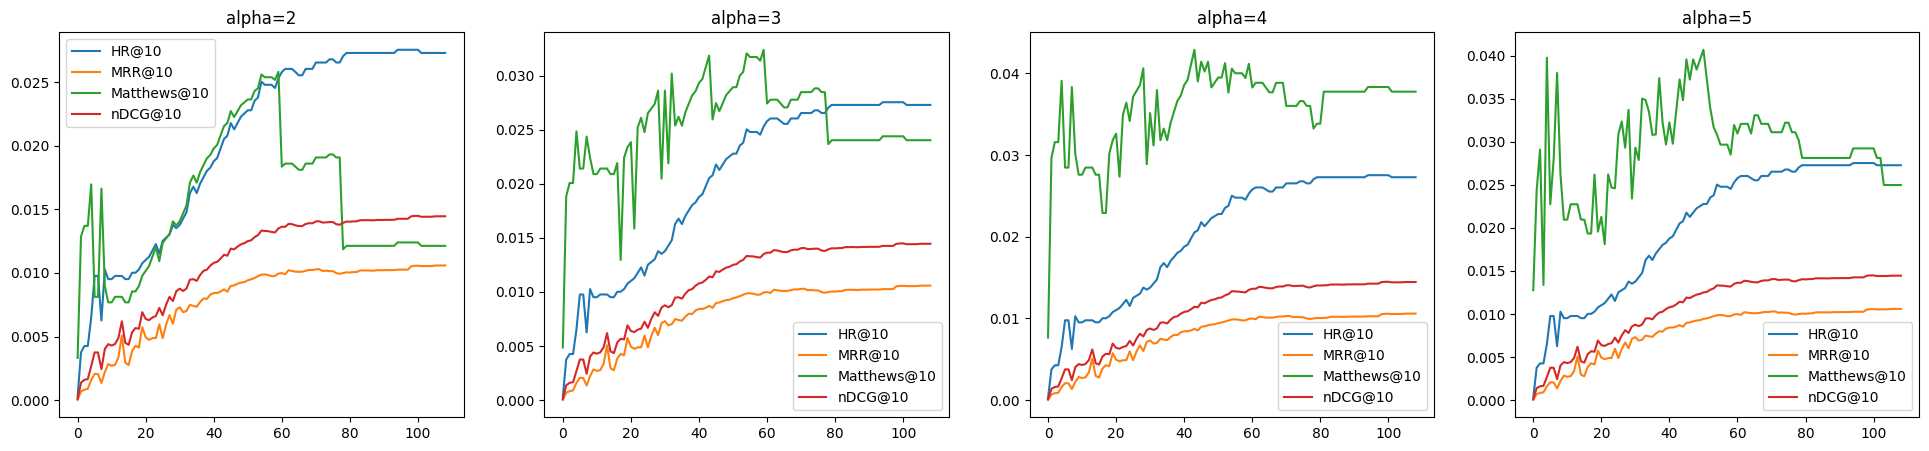

Test loss: 5.937300738878548e-05
Train loss: 9.382321845474675e-05


Hidden sizes: 64
Current epoch 158
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.026783  0.014139      0.0319  0.017277  0.026533   0.00025   0.013888   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00025    0.017027     0.00025    0.027033

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.0398  0.015869     0.044821  0.02148   0.039299   0.000501    0.015587   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000282     0.021151     0.000329     0.029897

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.066083  0.017653     0.063901  0.028076    0.06433   0.001752   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.017278    0.000374     0.027422     0.000654     0.020592

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.026783  0.014139      0.0319  0.017277  0.026283  0.000501   0.013763   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000375    0.016869    0.000408    0.039868

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.0398  0.015869     0.044821  0.02148   0.038298   0.001502    0.015359   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.00051     0.020747     0.000733     0.035106

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.066083  0.017653     0.063901  0.028076   0.061827   0.004255   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.016942     0.00071     0.026633     0.001442      0.02059

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.026783  0.014139      0.0319  0.017277  0.025031  0.001752   0.012637   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001502     0.01571    0.001567    0.052439

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.0398  0.015869     0.044821  0.02148   0.036295   0.003504    0.014141   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001728     0.019353     0.002127     0.052593

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.066083  0.017653     0.063901  0.028076   0.057322   0.008761   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.015545    0.002108       0.0246     0.003476     0.038479

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.026283  0.014026    0.031698  0.017073  0.019775  0.006508   0.010346   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00368    0.012686    0.004387    0.049215

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.039049  0.015778     0.044619  0.02125   0.029036   0.010013   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.011605    0.004173     0.015703     0.005547     0.056759

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.066083  0.017625     0.063295  0.028047   0.044305   0.021777   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.012621    0.005003      0.01951     0.008537     0.035084

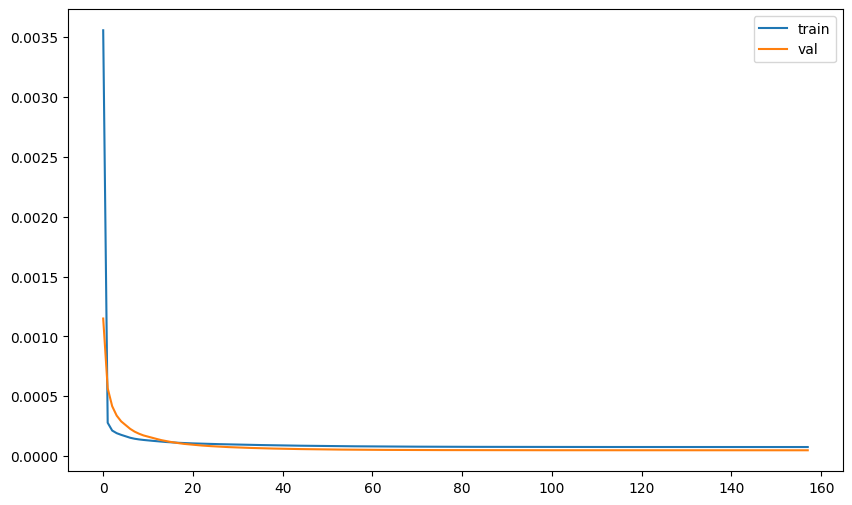

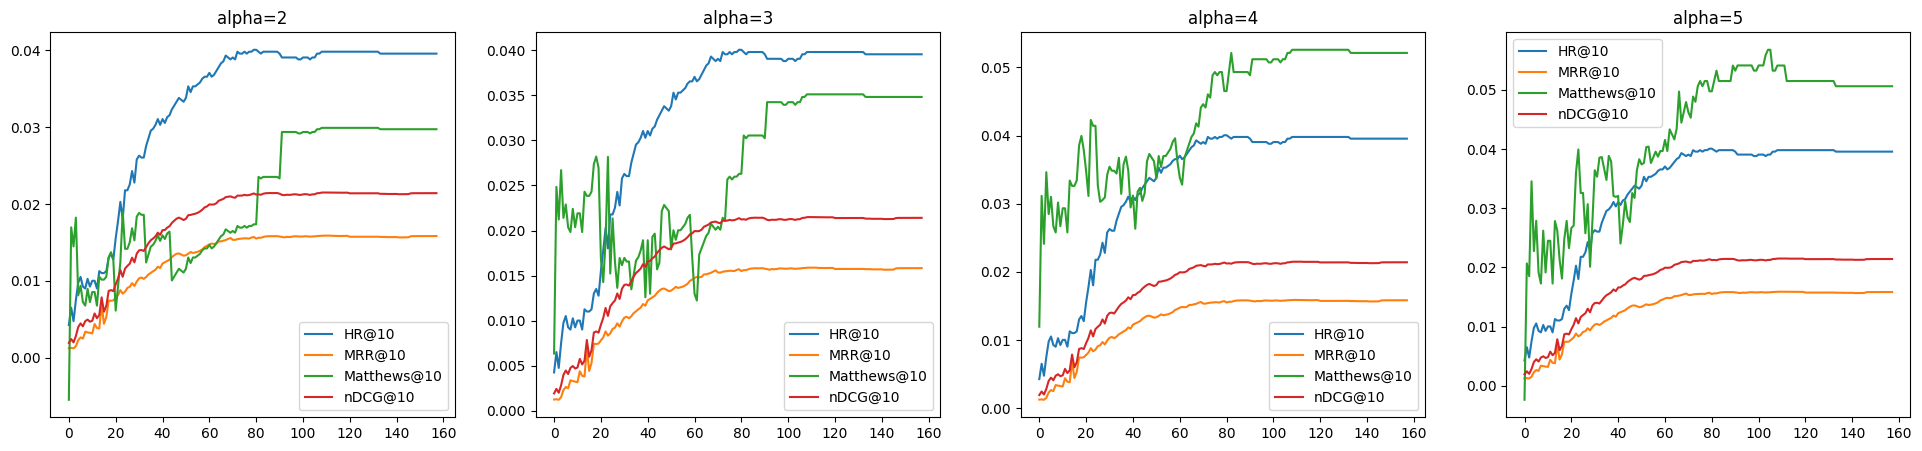

Test loss: 4.849867400480434e-05
Train loss: 7.577724141521048e-05


Hidden sizes: 128
Current epoch 101
Results for alpha=2


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.030038  0.01544    0.029174  0.019042  0.029287  0.000751   0.015211   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000229    0.018684    0.000358    0.014951

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.046308  0.017553     0.041692  0.024244   0.045557   0.000751   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.017324    0.000229     0.023886     0.000358     0.028365

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.070338  0.019217      0.06168  0.030315   0.068085   0.002253   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.018874    0.000343     0.029566     0.000749     0.013738

Results for alpha=3


HR@5    MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.02428  0.01252    0.019988  0.01541  0.023029  0.001252   0.011948   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000572    0.014671    0.000738    0.019435

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.040551  0.014588      0.02978  0.020569   0.038798   0.001752   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.013945    0.000643     0.019664     0.000905     0.031438

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.062328  0.016062     0.040985  0.026029   0.058073   0.004255   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.015235    0.000827     0.024478     0.001551     0.016391

Results for alpha=4


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.030038  0.01544    0.029174  0.019042  0.027284  0.002753   0.013771   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001669    0.017101    0.001941    0.043835

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.046308  0.017553     0.041692  0.024244   0.042053   0.004255   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.015691    0.001863     0.021824      0.00242     0.054763

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.070338  0.019217      0.06168  0.030315   0.062829   0.007509   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.01712    0.002097     0.027062     0.003253     0.057917

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.03204  0.018264    0.050878  0.021666  0.022278  0.009762   0.012599   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.005665     0.01499    0.006676    0.033251

HR@10   MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.050063  0.02067      0.07127  0.027494   0.035544   0.014518   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.01437      0.0063      0.01928     0.008214     0.048857

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.079099  0.022615     0.101757  0.034751   0.052315   0.026783   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.01548    0.007135     0.023455     0.011295     0.033219

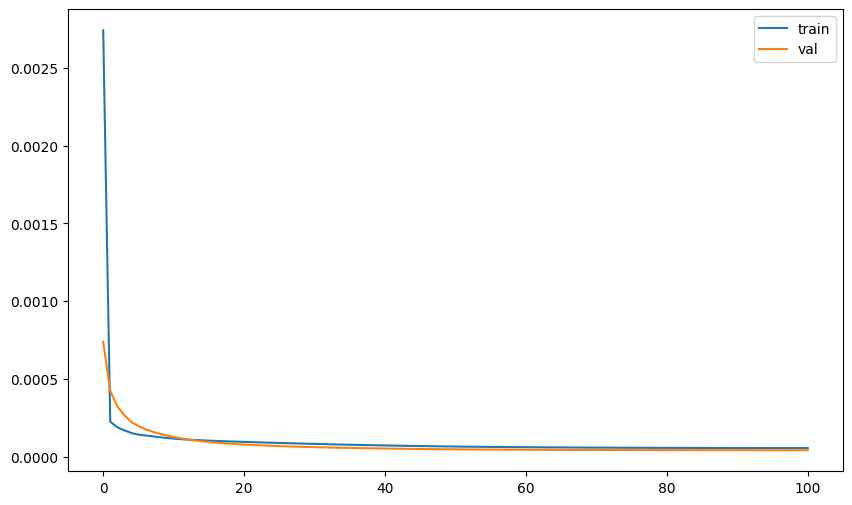

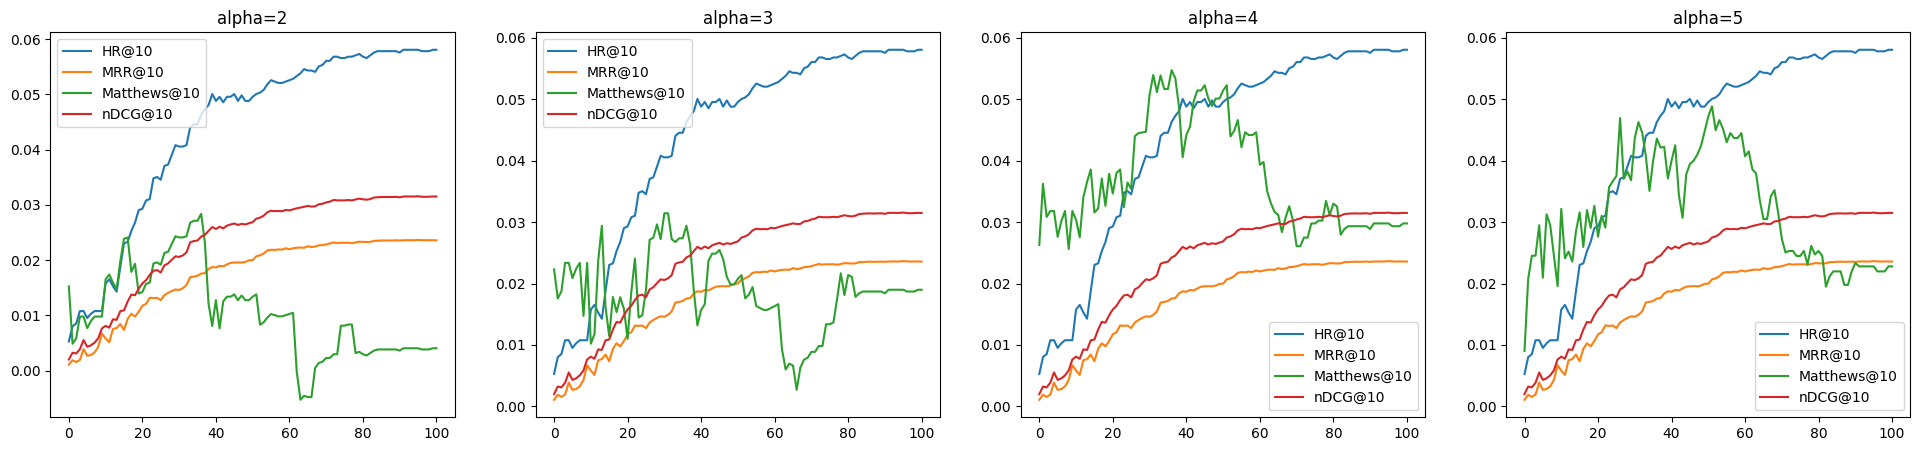

Test loss: 4.7913476009853184e-05
Train loss: 6.565740419721216e-05


Hidden sizes: 256


In [ ]:
sizes = 2**np.arange(4,10)
for batch_size in sizes:
    print('Batch size:', batch_size)
    tuning_pipeline(training, testset_valid, holdout_valid, data_description, base_model, device, grid, batch_size=batch_size)

In [ ]:
sizes = 2**np.arange(4,10)
for batch_size in sizes:
    tuning_pipeline_augment(training, testset_valid, holdout_valid, data_description, base_model, grid, device, MVDataset, batch_size=int(batch_size))

## VAE

In [70]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [97]:
alpha = 3

# training
vae_training = training[training['rating']>=alpha]
n_users = vae_training['userid'].max()+1
n_items = data_description['n_items']

rows, cols = vae_training['userid'], vae_training['movieid']
vae_train_data = sparse.csr_matrix((np.ones_like(rows),
                         (rows, cols)), dtype='float64',
                         shape=(n_users, n_items))

# validation
start_idx = min(testset_valid['userid'].min(), holdout_valid['userid'].min())
end_idx = max(testset_valid['userid'].max(), holdout_valid['userid'].max())

rows_tr, cols_tr = testset_valid['userid'] - start_idx, testset_valid['movieid']
rows_te, cols_te = holdout_valid['userid'] - start_idx, holdout_valid['movieid']

valid_in_data = sparse.csr_matrix((np.ones_like(rows_tr),
                         (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
valid_out_data = sparse.csr_matrix((np.ones_like(rows_te),
                         (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

# test
start_idx = min(testset['userid'].min(), holdout['userid'].min())
end_idx = max(testset['userid'].max(), holdout['userid'].max())

rows_tr, cols_tr = testset['userid'] - start_idx, testset['movieid']
rows_te, cols_te = holdout['userid'] - start_idx, holdout['movieid']

test_in_data = sparse.csr_matrix((np.ones_like(rows_tr),
                         (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
test_out_data = sparse.csr_matrix((np.ones_like(rows_te),
                         (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

In [105]:
np.sum(vae_train_data.A), np.sum(valid_in_data.A), np.sum(valid_out_data.A), np.sum(test_in_data.A), np.sum(test_out_data.A)

(462784.0, 196310.0, 1705.0, 198048.0, 1738.0)

In [129]:
def generate(batch_size, device, data_in, data_out=None, shuffle=False, samples_perc_per_epoch=1):
    assert 0 < samples_perc_per_epoch <= 1
    
    total_samples = data_in.shape[0]
    samples_per_epoch = int(total_samples * samples_perc_per_epoch)
    
    if shuffle:
        idxlist = np.arange(total_samples)
        np.random.shuffle(idxlist)
        idxlist = idxlist[:samples_per_epoch]
    else:
        idxlist = np.arange(samples_per_epoch)
    
    for st_idx in range(0, samples_per_epoch, batch_size):
        end_idx = min(st_idx + batch_size, samples_per_epoch)
        idx = idxlist[st_idx:end_idx]

        yield Batch(device, idx, data_in, data_out)


class Batch:
    def __init__(self, device, idx, data_in, data_out=None):
        self._device = device
        self._idx = idx
        self._data_in = data_in
        self._data_out = data_out
    
    def get_idx(self):
        return self._idx
    
    def get_idx_to_dev(self):
        return torch.LongTensor(self.get_idx()).to(self._device)
        
    def get_ratings(self, is_out=False):
        data = self._data_out if is_out else self._data_in
        return data[self._idx]
    
    def get_ratings_to_dev(self, is_out=False):
        return torch.Tensor(
            self.get_ratings(is_out).toarray()
        ).to(self._device)


def evaluate(model, data_in, data_out, metrics, samples_perc_per_epoch=1, batch_size=500):
    metrics = deepcopy(metrics)
    model.eval()
    
    for m in metrics:
        m['score'] = []
    
    for batch in generate(batch_size=batch_size,
                          device=device,
                          data_in=data_in,
                          data_out=data_out,
                          samples_perc_per_epoch=samples_perc_per_epoch
                         ):
        ratings_in = batch.get_ratings_to_dev()
#         print(ratings_in)
        ratings_out = batch.get_ratings(is_out=True)
#         print(ratings_out)
    
        ratings_pred = model(ratings_in, calculate_loss=False).cpu().detach().numpy()
#         print(ratings_pred)
        
        if not (data_in is data_out):
            ratings_pred[batch.get_ratings().nonzero()] = -np.inf
            
        for m in metrics:
            m['score'].append(m['metric'](ratings_pred, ratings_out, k=m['k']))

    for m in metrics:
        m['score'] = np.concatenate(m['score']).mean()
        
    return [x['score'] for x in metrics]


def run(model, opts, train_data, batch_size, n_epochs, beta, gamma, dropout_rate):
    model.train()
    for epoch in range(n_epochs):
        for batch in generate(batch_size=batch_size, device=device, data_in=train_data, shuffle=True):
            ratings = batch.get_ratings_to_dev()
#             print(ratings)

            for optimizer in opts:
                optimizer.zero_grad()
                
            a, loss = model(ratings, beta=beta, gamma=gamma, dropout_rate=dropout_rate)
            print(a, loss)
#             print(loss)
            loss.backward()
            
            for optimizer in opts:
                optimizer.step()

In [130]:
grid1 = np.arange(100, 2100, 100)
grid = np.meshgrid(grid1, grid1)

In [131]:
model_kwargs = {
    'hidden_dim': 100,
    'latent_dim': 100,
    'input_dim': vae_train_data.shape[1]
}
metrics = [{'metric': ndcg, 'k': 10}]

best_ndcg = -np.inf
train_scores, valid_scores = [], []

model = RecVAE(**model_kwargs).to(device)
model_best = RecVAE(**model_kwargs).to(device)

learning_kwargs = {
    'model': model,
    'train_data': vae_train_data,
    'batch_size': 512,
    'beta': None,
    'gamma': 0.005
}

decoder_params = set(model.decoder.parameters())
encoder_params = set(model.encoder.parameters())

optimizer_encoder = optim.Adam(encoder_params, lr=5e-4)
optimizer_decoder = optim.Adam(decoder_params, lr=5e-4)

n_epochs = 50

for epoch in range(n_epochs):

    run(opts=[optimizer_encoder], n_epochs=3, dropout_rate=0.5, **learning_kwargs)
    model.update_prior()
    run(opts=[optimizer_decoder], n_epochs=1, dropout_rate=0, **learning_kwargs)

    train_scores.append(
        evaluate(model, vae_train_data, vae_train_data, metrics, 0.01)[0]
    )
    valid_scores.append(
        evaluate(model, valid_in_data, valid_out_data, metrics, 1)[0]
    )
    
    if valid_scores[-1] > best_ndcg:
        best_ndcg = valid_scores[-1]
        model_best.load_state_dict(deepcopy(model.state_dict()))
        

    print(f'epoch {epoch} | valid ndcg@100: {valid_scores[-1]:.4f} | ' +
          f'best valid: {best_ndcg:.4f} | train ndcg@100: {train_scores[-1]:.4f}')


    
test_metrics = [{'metric': ndcg, 'k': 100}, {'metric': recall, 'k': 20}, {'metric': recall, 'k': 50}]

final_scores = evaluate(model_best, test_in_data, test_out_data, test_metrics)

for metric, score in zip(test_metrics, final_scores):
    print(f"{metric['metric'].__name__}@{metric['k']}:\t{score:.4f}")

(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, dev

C:\Users\Liza\Desktop\Thesis\RecVAE\utils.py:98: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


epoch 0 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.0184
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward

KeyboardInterrupt: 

In [106]:
valid_scores

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [ ]:
params = []
histories = []
test_losses = []
mrrs = []
hrs = []
cs = []


for h1, h2, in tqdm(zip(grid[0].flatten(), grid[1].flatten()), total=24):
    print('Hidden sizes:', h1, h2)
    
    vae = VAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters(), lr=5*1e-4)
    
    mask = torch.triu(torch.ones_like(ae.L.weight))
    # Register with hook
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    params.append(sum(p.numel() for p in ae.parameters() if p.requires_grad))
    
    # Training the AE
    n_epochs = 20
    history = []
    prev_train_loss = 1
    train_loss = 0.1 * len(train_dataloader)
    epoch = 1

    while prev_train_loss - train_loss / len(train_dataloader) > 1e-4 or train_loss / len(train_dataloader) > 1e-2:
        if epoch > 1:
            prev_train_loss = train_loss / len(train_dataloader)
        
        train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()

            user_tensor, user_matrix = batch

            input_tensor = user_tensor.to_dense().to(device)
            target = user_matrix.to_dense().to(device)

            output = ae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        history.append(train_loss / len(train_dataloader))
        epoch += 1
        
        if epoch > 50:
            break
    
    histories.append(history)
    
#         print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))
    
    # Testing the AE
    test_loss = 0

    for user in testset_valid.userid.unique():
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
        target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

        output = ae(user_tensor_test)
        target.require_grad = False

        loss = criterion(output, target)
        test_loss += loss.data.item()
    
    test_losses.append(test_loss / testset_valid.userid.nunique())

#     print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    scores = torch.zeros((len(testset_valid.userid.unique()), data_description['n_items']))
    for i, user in enumerate(testset_valid.userid.unique()):
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_matrix_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().unsqueeze(0).to(device)

        output = ae(user_matrix_test)
        scores[i] = output[0].T


    scores = scores.detach().numpy()
    
    # our
    plt.plot(history)
    plt.show()
    print('Test loss:', test_loss / testset_valid.userid.nunique())
    print('Epochs:', epoch)
    downvote_seen_items(scores, testset_valid, data_description)
    mrr10, hr10, c10 = make_prediction(scores, holdout_valid, data_description)
    mrrs.append(mrr10)
    hrs.append(hr10)
    cs.append(c10)
    
    print()
    print()

# Test metrics

In [22]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    n_ratings = training['rating'].nunique(),
    min_rating = training['rating'].min(),
    test_users = holdout[data_index['users'].name].drop_duplicates().values,
    n_test_users = holdout[data_index['users'].name].nunique()
)

In [23]:
train_val = pd.concat((training, testset_valid, holdout_valid))

## TopPop

In [24]:
pop_params = build_popularity_model(train_val, data_description)
pop_scores = popularity_model_scoring(pop_params, None, data_description)
downvote_seen_items(pop_scores, testset, data_description)

make_prediction(pop_scores, holdout, data_description, dcg=True, alpha=2)
make_prediction(pop_scores, holdout, data_description, dcg=True, alpha=3)
make_prediction(pop_scores, holdout, data_description, dcg=True, alpha=4)
make_prediction(pop_scores, holdout, data_description, dcg=True, alpha=5)

HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009876  0.004493    0.000995  0.00583  0.009283  0.000593   0.004033   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000461    0.005336    0.000494   -0.015732

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.016591  0.005302     0.001617  0.007914   0.015801    0.00079   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.004819    0.000483     0.007361     0.000553     -0.01135

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.03733  0.00666     0.002861  0.013051   0.036342   0.000988    0.006168   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000493     0.012453     0.000598     0.006403

HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009876  0.004493    0.000995  0.00583  0.009086   0.00079   0.003993   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5     0.0005     0.00526     0.00057   -0.003948

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.016591  0.005302     0.001617  0.007914   0.015208   0.001383   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.004738    0.000564     0.007168     0.000746    -0.006832

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.03733  0.00666     0.002861  0.013051   0.034169    0.00316    0.006005   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000656     0.011897     0.001155     -0.01138

HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009876  0.004493    0.000995  0.00583  0.008493  0.001383   0.003796   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000698    0.004964    0.000866    0.003307

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.016591  0.005302     0.001617  0.007914   0.013826   0.002765   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.004446    0.000856     0.006628     0.001287    -0.005349

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.03733  0.00666     0.002861  0.013051   0.031207   0.006123    0.005606   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.001054     0.010961     0.002091    -0.006658

HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009876  0.004493    0.000995  0.00583  0.006518  0.003358   0.002653   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00184    0.003612    0.002218   -0.004461

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.016591  0.005302     0.001617  0.007914   0.010073   0.006518   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.003094    0.002208     0.004729     0.003186    -0.020529

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.03733  0.00666     0.002861  0.013051   0.023109   0.014221    0.003999   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.002661     0.008023     0.005028    -0.026095

(0.005301612382394527,
 0.016590953979853842,
 -0.020529466946874006,
 0.007914271892119875)

## Normalized PureSVD

In [ ]:
svd_params = build_svd_model({'rank':1536, 'f':0.4}, train_val, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)
make_prediction(svd_scores, holdout, data_description, dcg=True, alpha=2)

svd_params = build_svd_model({'rank':1536, 'f':0.4}, train_val, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)
make_prediction(svd_scores, holdout, data_description, dcg=True, alpha=3)

svd_params = build_svd_model({'rank':64, 'f':1.0}, train_val, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)
make_prediction(svd_scores, holdout, data_description, dcg=True, alpha=4)

svd_params = build_svd_model({'rank':96, 'f':0.7}, train_val, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)
make_prediction(svd_scores, holdout, data_description, dcg=True, alpha=5)

## EASEr

In [33]:
easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)
make_prediction(easer_scores, holdout, data_description, dcg=True, alpha=2)

easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)
make_prediction(easer_scores, holdout, data_description, dcg=True, alpha=3)

easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)
make_prediction(easer_scores, holdout, data_description, dcg=True, alpha=4)

easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)
make_prediction(easer_scores, holdout, data_description, dcg=True, alpha=5)

HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.070086  0.040917    0.507672  0.048153  0.066618  0.003468   0.038943   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001974    0.045812    0.002341    0.045204

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.099653  0.044846     0.680699  0.057699   0.094543    0.00511   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.042643    0.002203     0.054817     0.002882     0.052768

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.134879  0.047187     0.830709  0.066476   0.127396   0.007483   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.044825    0.002362     0.063001     0.003475     0.057065

(0.04484641213058808,
 0.09965322139076474,
 0.052767573990321705,
 0.057699332516444615)

## CoFFee

In [ ]:
config['mlrank'] = (256, 256, 2)
tf_params = tf_model_build(config, train_val, data_description)
seen_data = testset
tf_scores = tf_scoring(tf_params, seen_data, data_description)
downvote_seen_items(tf_scores, seen_data, data_description)

make_prediction(tf_scores, holdout, data_description, dcg=True, alpha=2)
make_prediction(tf_scores, holdout, data_description, dcg=True, alpha=3)
make_prediction(tf_scores, holdout, data_description, dcg=True, alpha=4)
make_prediction(tf_scores, holdout, data_description, dcg=True, alpha=5)

## Simple AE


In [51]:
h = ...
batch_size = ...
training_testing_pipeline(training, testset_valid, holdout_valid, testset, holdout, data_description, base_model, h, device, batch_size=batch_size)
# training_testing_pipeline_augment(training, testset_valid, holdout_valid, testset, holdout, data_description, model_init, h, device, MVDataset, batch_size=batch_size)

KeyboardInterrupt: 